In [128]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import matplotlib
from mantid.simpleapi import *
import matplotlib.patheffects as PathEffects
import matplotlib.patheffects as PathEffects
cwd=os.getcwd()
sys.path.append("../python scripts/")


from nxspetomd import *
from genslices import *
import MDUtils as mdu
from getcolor import *
from cut_mdhisto_powder import *
from mdfactorization import *
from trapzerr import *
from mask_minQ import *
from maskQEbox import *
#Style sheet updates 
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'
plt.close('all')
%matplotlib inline

# This notebook performs the factorization analysis on all three measurements as defined in the main text. It also makes plots of the scattering for the text.

The order is the following :

1. First plot showing SEQUOIA magnetic scattering at 4 K and 100 K with accompanying cuts of raw data
2. Second plot with MACS Data
3. Third plot with MACS, SEQUOIA factorizations
4. Final plot showing polarized scattering results. 

In [129]:
#Load the files correctly, sort into a dictionary.

mds = {}
keys= ['seq_mag','seq_100K','macs_5mag','macs_3p7mag','hys_mag','hys_SF','seq_mag_60meV',\
       'macs_2K_5meV','macs_55K_5meV','macs_2K_3p7meV','macs_55K_3p7meV','hys_SI','hys_NSF']
fdict = {keys[0]:'../MDHisto_files/30_4K_SEQ_mag.nxs',\
        keys[1]:'../MDHisto_files/30_100K_SEQ_mag.nxs',\
        keys[2]:'../MDHisto_files/HLIO_MACS_5p0_mag.nxs',\
        keys[3]:'../MDHisto_files/HLIO_MACS_3p7_mag.nxs',\
        keys[4]:'../MDHisto_files/HLIO_mag_avg.nxspe',\
        keys[5]:'../MDHisto_files/HLIO_tot_SF.nxspe',\
        keys[6]:'../MDHisto_files/60_4K_SEQ_mag.nxs',\
        keys[7]:'../MDHisto_files/macs_5p0_2K.nxs',\
        keys[8]:'../MDHisto_files/macs_5p0_55K.nxs',\
        keys[9]:'../MDHisto_files/macs_3p7_2K.nxs',\
        keys[10]:'../MDHisto_files/macs_3p7_55K.nxs',\
        keys[11]:'../MDHisto_files/HLIO_SI.nxspe',\
        keys[12]:'../MDHisto_files/HLIO_tot_NSF.nxspe'}

qslice_mag = GenQslice(0,3,15)
eslice_mag = GenEslice(0,20,10)
qslice_hys = GenQslice(0,3,60)
eslice_hys = GenEslice(0,20,60)
Qslices={keys[4]:qslice_mag,keys[5]:qslice_hys,keys[11]:qslice_hys,keys[12]:qslice_hys}
Eslices={keys[4]:eslice_mag,keys[5]:eslice_hys,keys[11]:eslice_hys,keys[12]:eslice_hys}
for key in keys:
    if 'nxspe' not in fdict[key]:
        ws = LoadMD(fdict[key])
        #For SEQ measurements, mask low angles.
        if 'SEQ' in fdict[key]:
            fname = fdict[key]
            Ei = float(fname.split('/')[-1].split('_')[0])
            ws = mask_minQ_fixedEi_MD(ws,twoThetaMin=4.5,Ei=Ei)
        if 'macs' in fdict[key]:
            fname = fdict[key]
            Ef = float(fname.split('/')[-1].split('_')[1].replace('p','.'))
            ws = mask_minQ_fixedEf_MD(ws,twoThetaMin=12.0,Ef=Ef)
        outws=CloneWorkspace(ws,OutputWorkspace=key)
        mds[key]=outws
    else:
        #HYS data needs to be binned. 
        md = NxspeToMDHisto(fdict[key],Qslices[key],Eslices[key],numEvNorm=False)
        hysscale=1.2e5
        md*=hysscale
        outws=CloneWorkspace(md,OutputWorkspace=key)
        mds[key]=outws        

constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.


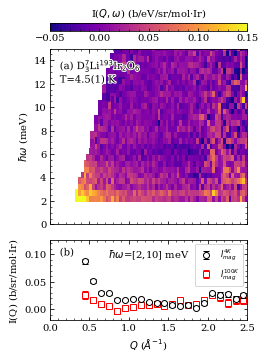

In [130]:
#Begin with a figure showing the SEQUOIA scattering and accompanying cuts

fig=plt.figure(constrained_layout=True,figsize=(3.54,5))

gs = matplotlib.gridspec.GridSpec(3,1,figure=fig)
ax_slice = fig.add_subplot(gs[0:2],projection='mantid')
ax_qcut = fig.add_subplot(gs[2])
#perform the appropriate masking of the elastic line.

ws_masked_60= mask_QE_box_MD(mtd['seq_mag_60meV'],[0,5],[0,3])
ws_masked_60 = CloneWorkspace(ws_masked_60,OutputWorkspace='seq_mag_60meV_plot')
ws_masked_60 = SmoothMD(ws_masked_60,'Hat',WidthVector=1)

ws_masked= mask_QE_box_MD(mtd['seq_mag'],[0,5],[0,1.8])
ws_masked = CloneWorkspace(ws_masked,OutputWorkspace='seq_mag_plot')
ws_masked = SmoothMD(ws_masked,'Hat',WidthVector=1)

cmap='plasma'
vmin=-0.05
vmax=0.15
mesh=ax_slice.pcolormesh(ws_masked_60,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True,zorder=1)

mesh=ax_slice.pcolormesh(ws_masked,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True,zorder=2)
ax_slice.set_ylim(0,15)
ax_slice.set_xlabel('')
ax_slice.set_ylabel('$\hbar\omega$ (meV)')
ax_slice.set_xticklabels([])

txta = ax_slice.text(0.05,0.95,'(a) D$_3^7$Li$^{193}$Ir$_2$O$_6$\nT=4.5(1) K',transform=ax_slice.transAxes,\
                    horizontalalignment='left',verticalalignment='top')
txta.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Add a colorbar
l,b,w,h=ax_slice.get_position().bounds
cax = fig.add_axes([l,b+h+0.05,w,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/mol$\cdot$Ir)'
cbar = plt.colorbar(mesh,orientation='horizontal',cax=cax)
cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',verticalalignment='bottom')
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))

#Plot cuts of both the 100 K and 4 K magnetic scattering. 
qbins=[0,3,0.1]
ebins=[2,10]
q4,i4,err4 = cut_MDHisto_powder(mtd['seq_mag'],'|Q|',qbins,ebins)
q100,i100,err100=cut_MDHisto_powder(mtd['seq_100K'],'|Q|',qbins,ebins)
ax_qcut.errorbar(q4,i4,err4,color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=3,label='$I_{mag}^{4K}$',\
                zorder=10)
ax_qcut.errorbar(q100,i100,err100,color='r',marker='s',mfc='w',mec='r',ls=' ',capsize=3,\
                 zorder=5,label='$I_{mag}^{100K}$')
ax_qcut.legend(fontsize=8,loc=1,ncol=1)

txtb = ax_qcut.text(0.05,0.90,'(b)',transform=ax_qcut.transAxes,\
                    horizontalalignment='left',verticalalignment='top',)
txtb.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

txtb2 = ax_qcut.text(0.5,0.90, '$\hbar\omega$=[2,10] meV',transform=ax_qcut.transAxes,horizontalalignment='center',\
                    verticalalignment='top')

#Make x limits consistent
ax_slice.set_xlim(0,2.5)
ax_qcut.set_xlim(0,2.5)
ax_qcut.set_ylim(-0.02,0.125)

ax_qcut.set_xlabel('$Q$ ($\AA^{-1}$)')
ax_qcut.set_ylabel('I(Q) (b/sr/mol$\cdot$Ir)')

fig.savefig('DLIO_SEQ_scattering.pdf',bbox_inches='tight',dpi=400)

## The factorization of the above scattering is handled in the script mdfactorization.py

Be wary that the calculation of uncertainties takes a significant amount of time (~10 min on test desktop). To skip that calculation, set fast_mode=True for a 30% error bar. Feel free to load the pre-calculated factorization.

The plot for the factorization will be 

fit A0.01467231524322065
fit B2.5255827622207723
fit C0.9764107180932868


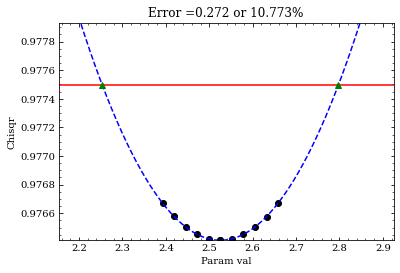

[                                        ]  1/69 (  1%) 68 to go

fit A0.016502862347210212
fit B2.163293725560974
fit C0.9764107181741819


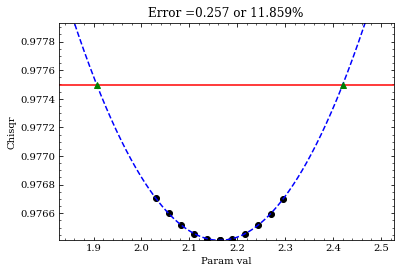

[=                                       ]  2/69 (  2%) 67 to go

fit A0.020430322519492658
fit B1.873052523329022
fit C0.9764107182848005


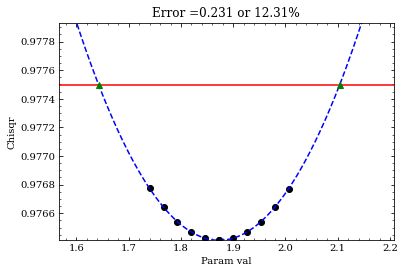

[=                                       ]  3/69 (  4%) 66 to go

fit A0.024210720658659573
fit B1.6142828107480625
fit C0.9764107181465117


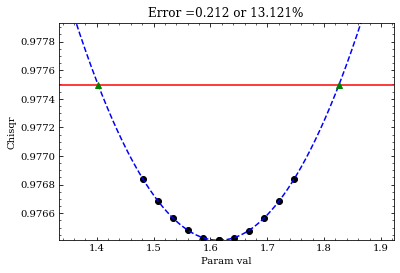

[==                                      ]  4/69 (  5%) 65 to go

fit A0.026940273874651265
fit B1.7721981504552653
fit C0.9764107180833456


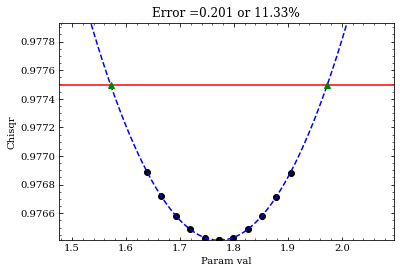

[==                                      ]  5/69 (  7%) 64 to go

fit A0.036699771235069165
fit B1.421178631364629
fit C0.9764107181346674


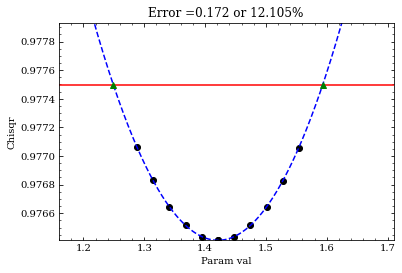

[===                                     ]  6/69 (  8%) 63 to go

fit A0.036153271007117724
fit B1.5830601658462091
fit C0.9764107181274156


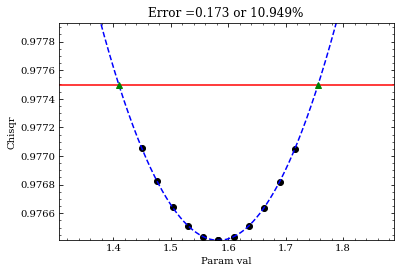

[====                                    ]  7/69 ( 10%) 62 to go

fit A0.03881066598258997
fit B1.3578710586120408
fit C0.9764107181540314


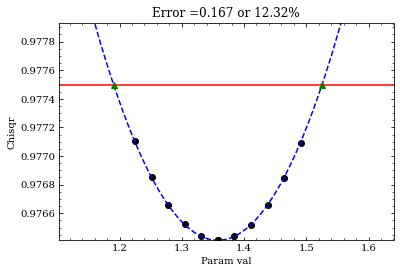

[====                                    ]  8/69 ( 11%) 61 to go

fit A0.033980865513649434
fit B1.832388822191083
fit C0.9764107182155382


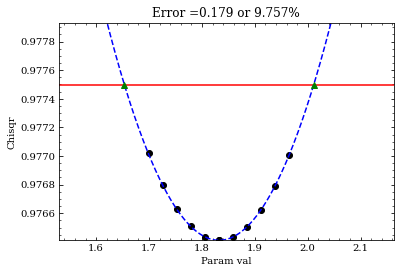

[=====                                   ]  9/69 ( 13%) 60 to go

fit A0.042691886781501695
fit B1.0091517930447256
fit C0.9764107180813847


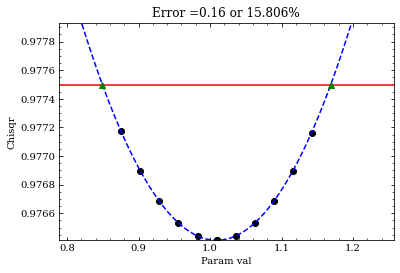

[=====                                   ] 10/69 ( 14%) 59 to go

fit A0.0428342803404191
fit B1.2480766785952884
fit C0.976410718070403


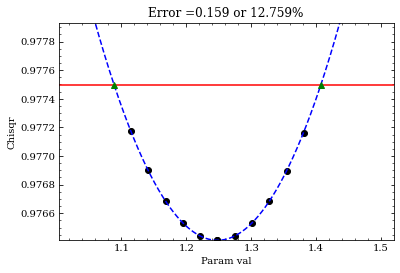

[======                                  ] 11/69 ( 15%) 58 to go

fit A0.05815387928825236
fit B0.9591036727734031
fit C0.9764107180865851


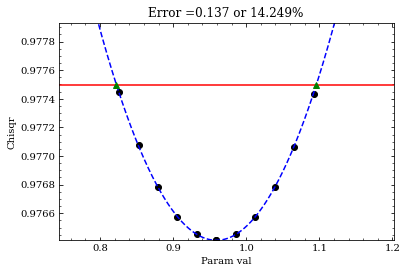

[======                                  ] 12/69 ( 17%) 57 to go

fit A0.05353048541213057
fit B1.1217087943306936
fit C0.9764107181467434


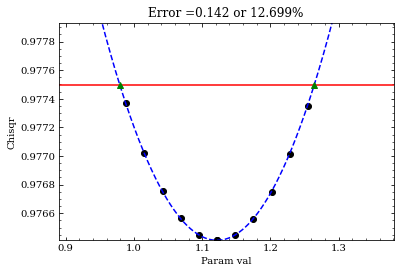

[=======                                 ] 13/69 ( 18%) 56 to go

fit A0.05460392062148383
fit B0.815679796662529
fit C0.9764107181611876


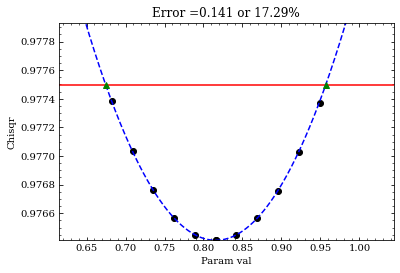

[========                                ] 14/69 ( 20%) 55 to go

fit A0.05452512219808106
fit B0.9215292078931236
fit C0.9764107183772551


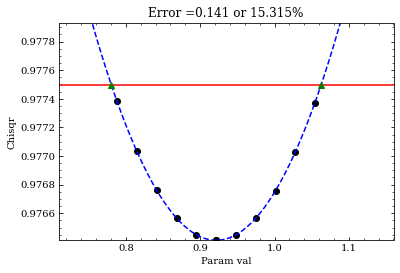

[========                                ] 15/69 ( 21%) 54 to go

fit A0.055578384522204885
fit B0.9579053498599673
fit C0.9764107181093191


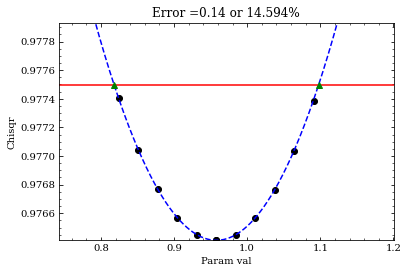

[=========                               ] 16/69 ( 23%) 53 to go

fit A0.053293653498417824
fit B1.2377086110057494
fit C0.9764107180694577


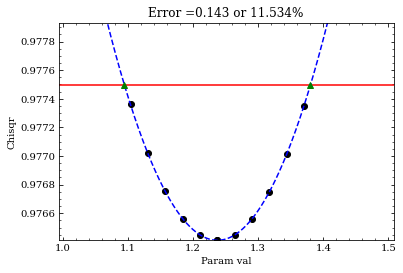

[=========                               ] 17/69 ( 24%) 52 to go

fit A0.07738253871794373
fit B0.8798012222005437
fit C0.9764107185471711


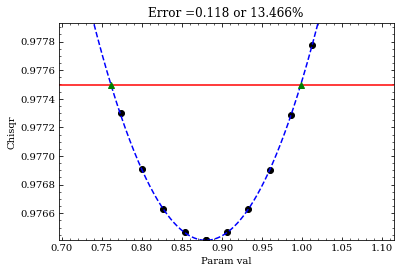

[==========                              ] 18/69 ( 26%) 51 to go

fit A0.056721384008939016
fit B1.13619140217002
fit C0.9764107181065206


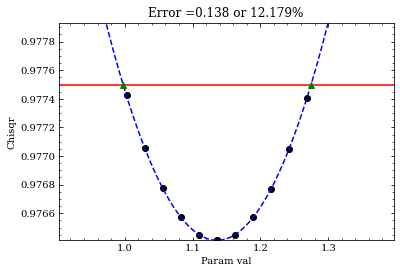

[===========                             ] 19/69 ( 27%) 50 to go

fit A0.05735561958771406
fit B1.0627911698065442
fit C0.9764107180770183


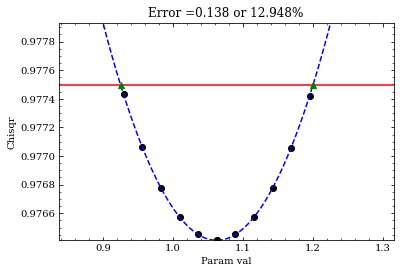

[===========                             ] 20/69 ( 28%) 49 to go

fit A0.05823212941786177
fit B0.8215874303831113
fit C0.9764107180700572


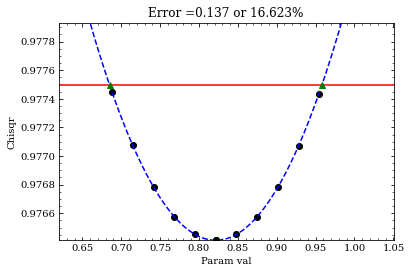

[============                            ] 21/69 ( 30%) 48 to go

fit A0.052521643775887764
fit B1.0956509687563023
fit C0.9764107180679209


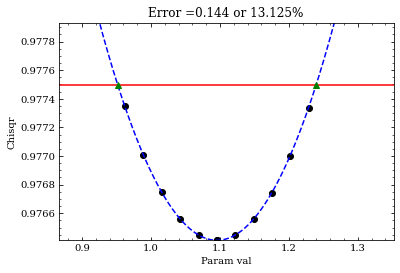

[============                            ] 22/69 ( 31%) 47 to go

fit A0.05566927655590873
fit B0.7346863976875201
fit C0.9764107188343255


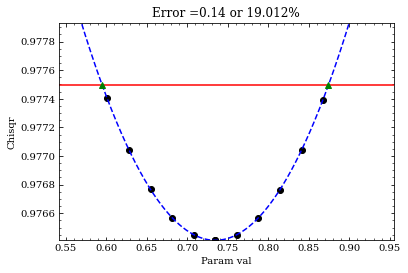

[=============                           ] 23/69 ( 33%) 46 to go

fit A0.05561588081637347
fit B0.9533082688395826
fit C0.9764107183144312


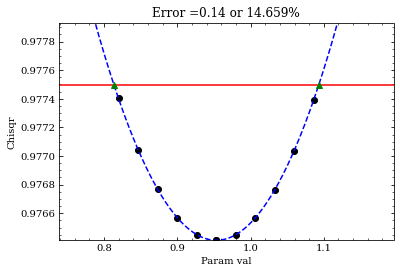

[=============                           ] 24/69 ( 34%) 45 to go

fit A0.047082726082828194
fit B0.7721495249738355
fit C0.9764107180828827


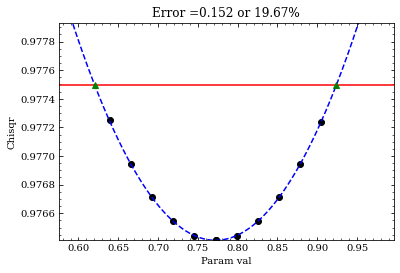

[==============                          ] 25/69 ( 36%) 44 to go

fit A0.04630699821219843
fit B0.8616578989996159
fit C0.9764107184969362


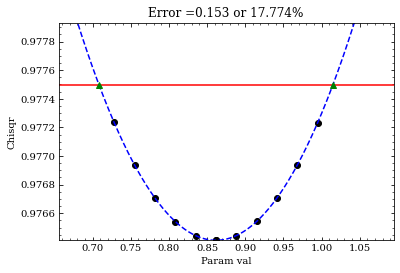

[===============                         ] 26/69 ( 37%) 43 to go

fit A0.04574134286909525
fit B0.8916358601161986
fit C0.9764107183139008


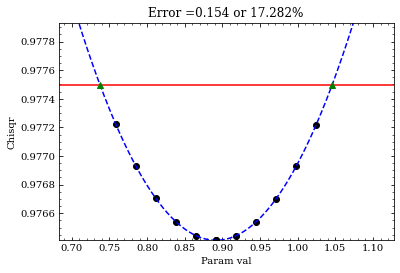

[===============                         ] 27/69 ( 39%) 42 to go

fit A0.05341732284104489
fit B0.8746220617911409
fit C0.9764107183194543


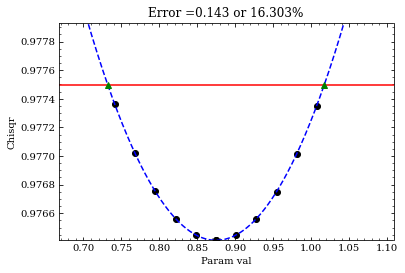

[================                        ] 28/69 ( 40%) 41 to go

fit A0.051111336179146497
fit B0.8351082313015599
fit C0.976410718116456


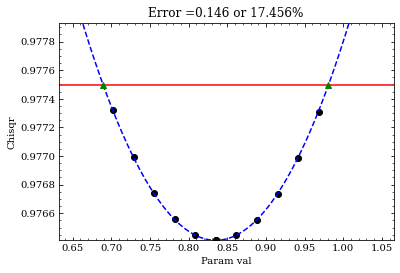

[================                        ] 29/69 ( 42%) 40 to go

fit A0.0481179922800251
fit B0.9145336112161452
fit C0.9764107188182862


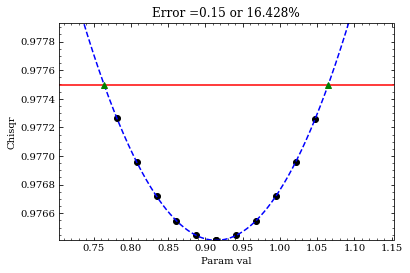

[=================                       ] 30/69 ( 43%) 39 to go

fit A0.04242103793604484
fit B0.572258729309501
fit C0.9764107183070113


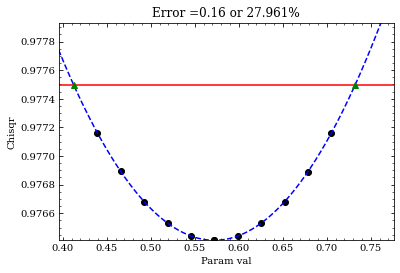

[=================                       ] 31/69 ( 44%) 38 to go

fit A0.04406637495850943
fit B0.5963039451940272
fit C0.976410718325821


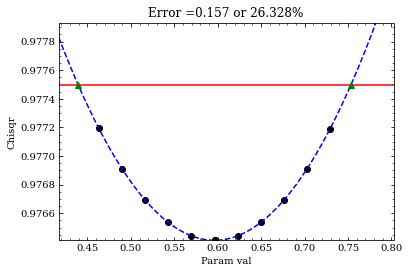

[==================                      ] 32/69 ( 46%) 37 to go

fit A0.04092798742283437
fit B0.6212244183215313
fit C0.9764107183130825


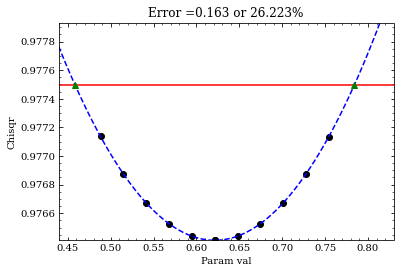

[===================                     ] 33/69 ( 47%) 36 to go

fit A0.043867711742751246
fit B0.6039742473857181
fit C0.9764107181517212


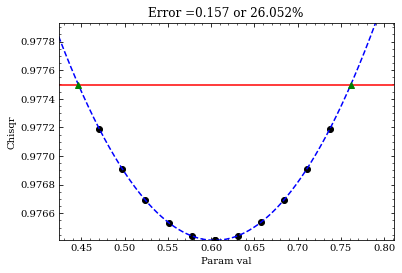

[===================                     ] 34/69 ( 49%) 35 to go

fit A0.040010582872463084
fit B0.5813208678002572
fit C0.9764107182495122


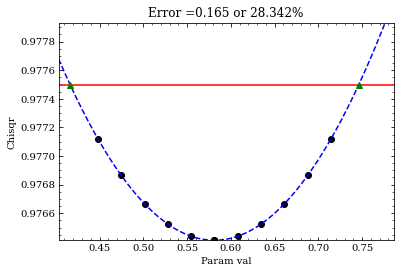

[====================                    ] 35/69 ( 50%) 34 to go

fit A0.04008595107952392
fit B0.6197380318057961
fit C0.9764107180982232


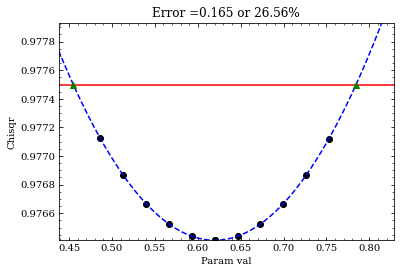

[====================                    ] 36/69 ( 52%) 33 to go

fit A0.03521376347341606
fit B0.766206347768697
fit C0.9764107180657252


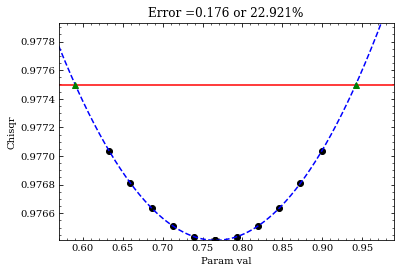

[=====================                   ] 37/69 ( 53%) 32 to go

fit A0.03415319159123537
fit B0.6554728939534774
fit C0.9764107181041879


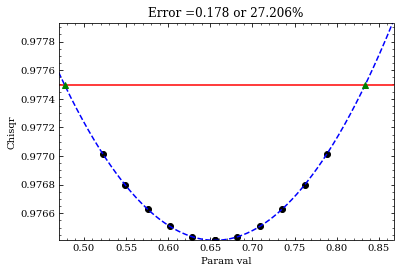

[======================                  ] 38/69 ( 55%) 31 to go

fit A0.035069961008536
fit B0.4767678145395714
fit C0.9764107181789982


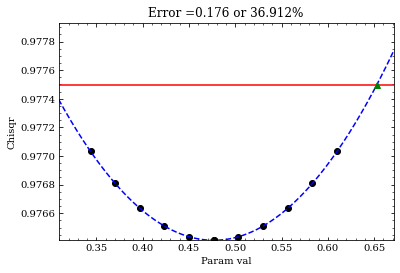

[======================                  ] 39/69 ( 56%) 30 to go

fit A0.03319375347541191
fit B0.13658973523342893
fit C0.97641071826367


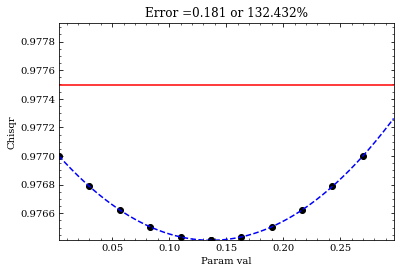

[=======================                 ] 40/69 ( 57%) 29 to go

fit A0.030587251510568514
fit B0.7613709032434282
fit C0.9764107180684612


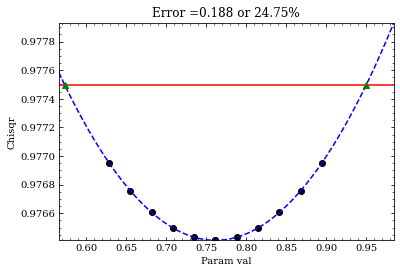

[=======================                 ] 41/69 ( 59%) 28 to go

fit A0.021910794475777817
fit B0.6679485922716573
fit C0.9764107181634671


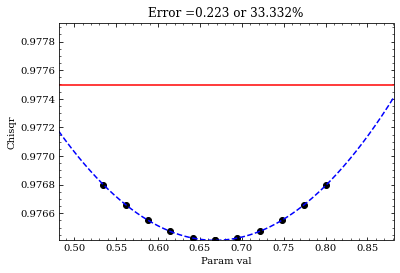

[========================                ] 42/69 ( 60%) 27 to go

fit A0.02083783525658811
fit B0.8594901753530791
fit C0.9764107185097939


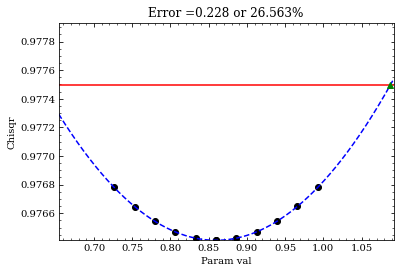

[========================                ] 43/69 ( 62%) 26 to go

fit A57.72706543422431
fit B0.04766472068084238
fit C0.9764107180703288


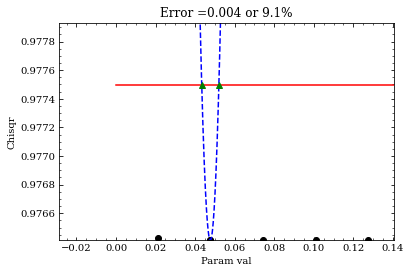

[=========================               ] 44/69 ( 63%) 25 to go

fit A12.593630054814962
fit B0.05267093281817403
fit C0.9764107181731464


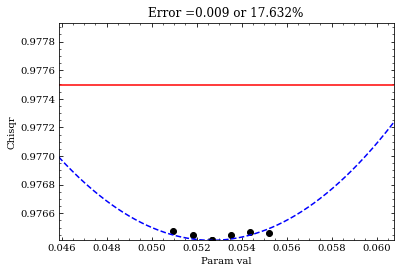

[==========================              ] 45/69 ( 65%) 24 to go

fit A60.67300594733607
fit B0.022780905912574756
fit C0.9764107180660694


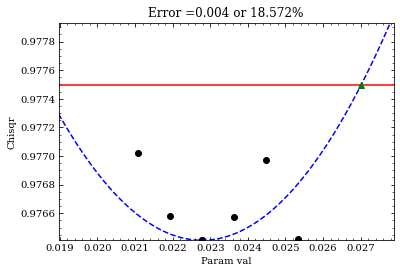

[==========================              ] 46/69 ( 66%) 23 to go

fit A27.849606353534917
fit B0.02756965670200673
fit C0.9764107180673075


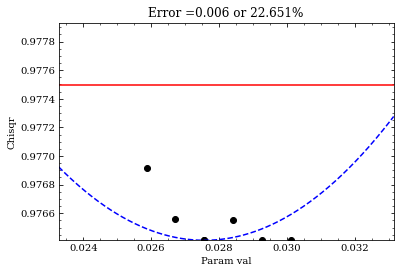

[===========================             ] 47/69 ( 68%) 22 to go

fit A61.407575332043216
fit B0.020626943590188684
fit C0.9764107181059656


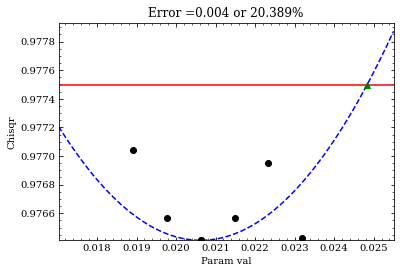

[===========================             ] 48/69 ( 69%) 21 to go

fit A65.14350431827103
fit B0.020062224823297337
fit C0.97641071807918


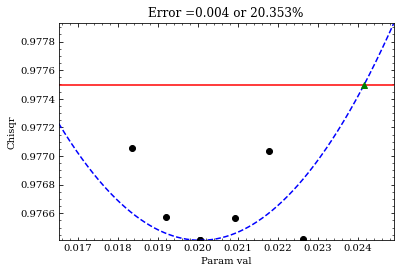

[============================            ] 49/69 ( 71%) 20 to go

fit A222.81533609019147
fit B0.013929044928484124
fit C0.9764107180743707


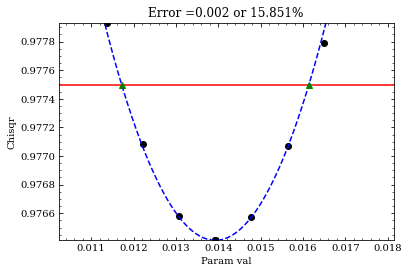

[============================            ] 50/69 ( 72%) 19 to go

fit A251.22416187376515
fit B0.004847892282826338
fit C0.9764107180678455


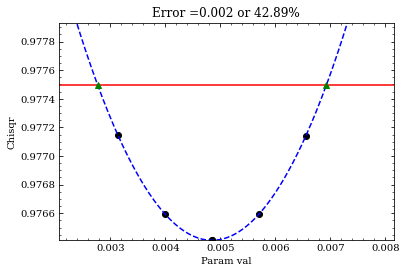

[=============================           ] 51/69 ( 73%) 18 to go

fit A490.2479327157856
fit B0.0
fit C0.975652631038536


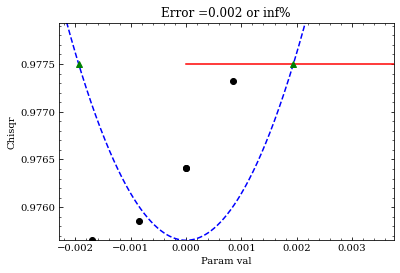

[==============================          ] 52/69 ( 75%) 17 to go

fit A220.70181216456427
fit B0.0004895336486236967
fit C0.976410718116895


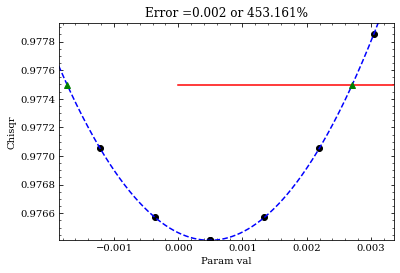

[==============================          ] 53/69 ( 76%) 16 to go

fit A201.14840271826915
fit B0.008461314178989321
fit C0.9764107180657893


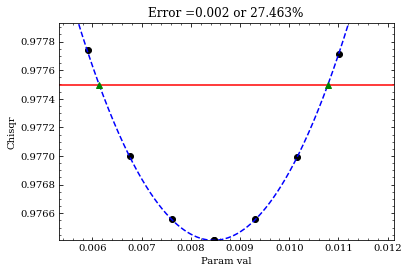

[===============================         ] 54/69 ( 78%) 15 to go

fit A192.3149498997512
fit B0.007351370887623165
fit C0.9764107180675892


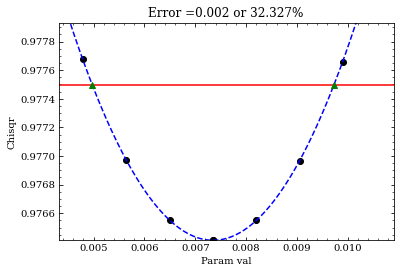

[===============================         ] 55/69 ( 79%) 14 to go

fit A176.47122525585502
fit B0.013150433313723564
fit C0.9764107181291708


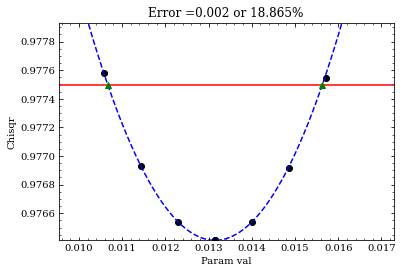

[================================        ] 56/69 ( 81%) 13 to go

fit A178.19016528626076
fit B0.004695264632774476
fit C0.9764107180765752


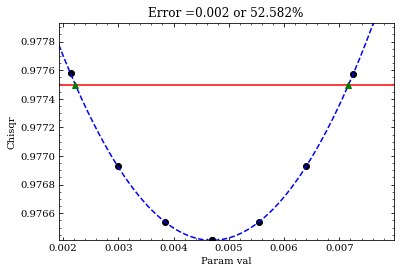

[=================================       ] 57/69 ( 82%) 12 to go

fit A165.64186119980872
fit B0.007256755843557006
fit C0.9764107180663082


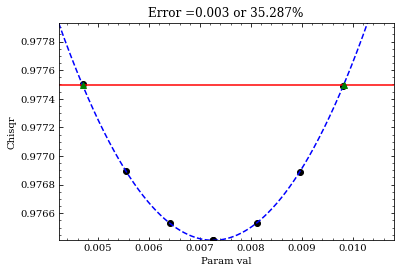

[=================================       ] 58/69 ( 84%) 11 to go

fit A156.30398010403758
fit B0.007917862346446203
fit C0.9764107180697162


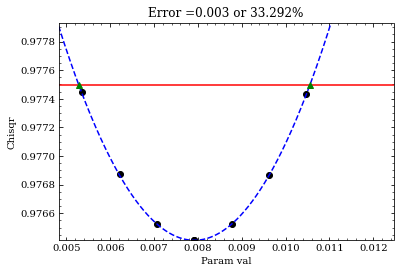

[==================================      ] 59/69 ( 85%) 10 to go

fit A151.85439238148103
fit B0.0020923296358124066
fit C0.9764107180724244


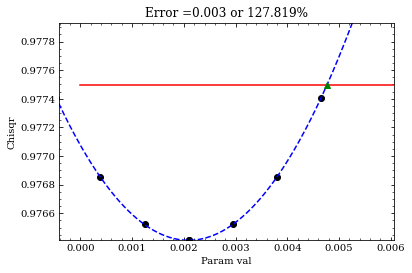

[==================================      ] 60/69 ( 86%)  9 to go

fit A146.7260416041881
fit B0.003330128762316642
fit C0.97641071806747


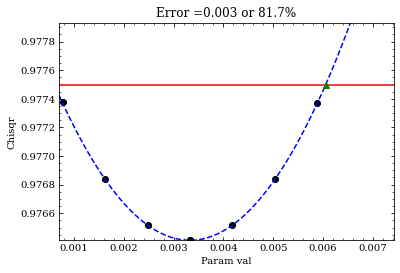

[===================================     ] 61/69 ( 88%)  8 to go

fit A135.22069134963175
fit B0.008367286329079793
fit C0.9764107180657877


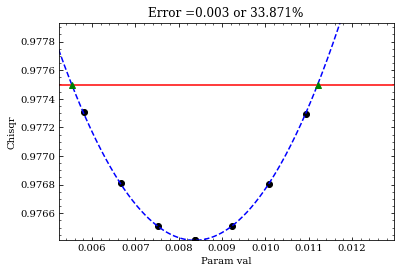

[===================================     ] 62/69 ( 89%)  7 to go

fit A258.7858682919465
fit B0.0
fit C0.976024346125986


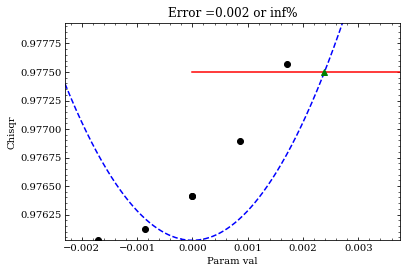

[====================================    ] 63/69 ( 91%)  6 to go

fit A129.73559178928033
fit B0.003706642320740139
fit C0.9764107180706272


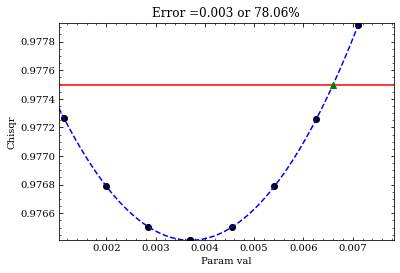

[=====================================   ] 64/69 ( 92%)  5 to go

fit A120.76517834642759
fit B0.003901738748314898
fit C0.9764107180723695


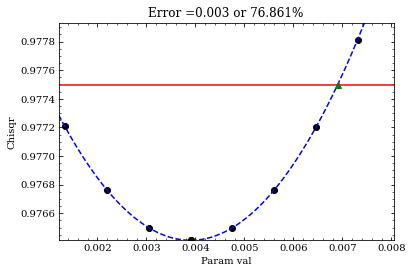

[=====================================   ] 65/69 ( 94%)  4 to go

fit A115.03245752729227
fit B0.007320443980721736
fit C0.9764107180740751


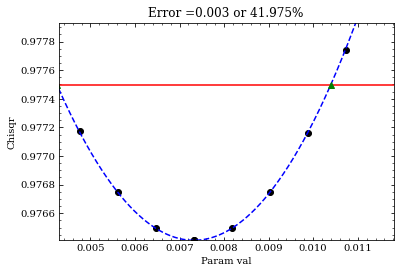

[======================================  ] 66/69 ( 95%)  3 to go

fit A107.79436594377282
fit B0.007966477871184319
fit C0.9764107180679997


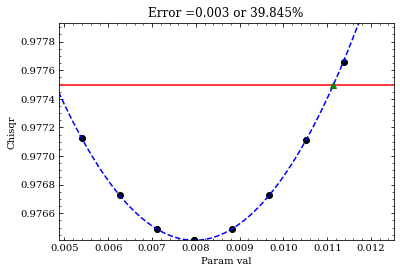

[======================================  ] 67/69 ( 97%)  2 to go

fit A99.21059155901801
fit B0.006868333150184869
fit C0.976410718154945


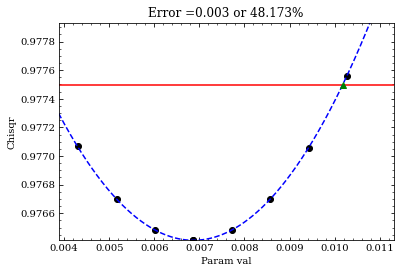

[======================================= ] 68/69 ( 98%)  1 to go

fit A92.77933831430757
fit B0.006453697504148037
fit C0.9764107180749945


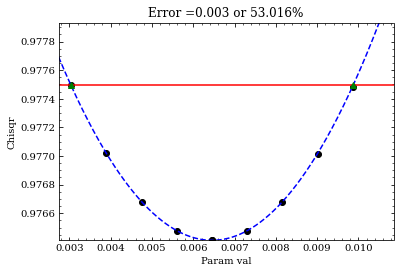

[========================================] 69/69 (100%)  0 to go

In [171]:
seq_factor_fname='SEQ_fact.npy'
qseq,sqseq,sqerrseq,eseq,geseq,geerrseq=MDfactorization(mtd['seq_mag'],mag_ion='Ir4',\
                                     q_lim=[0.5,2.0],e_lim=[2.0,15.0],Ei=60.0,\
                                     twoThetaMin=4.0,plot_result=False,method='powell',fname=seq_factor_fname,\
                                     overwrite_prev=True,allow_neg_E=False,g_factor=2.0,fast_mode=False)

Mu_eff from factorization=1.97(0.371) muB


<ErrorbarContainer object of 3 artists>

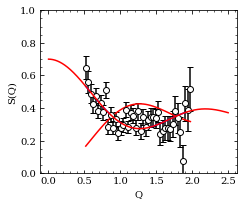

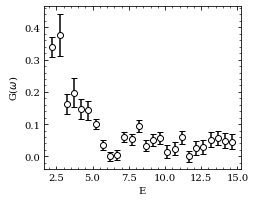

In [172]:
#Quick plot offactorization below.
norm_err = 0.3# as a percent error
frac_err = norm_err#*sqseq/sqerrseq
#Also check the measured moment. 
mu_eff = np.sqrt(3.0*(2.0**2)*np.trapz(sqseq*(qseq**2),x=qseq)/np.trapz(qseq**2,x=qseq))
muerrsqr = 3.0*(2.0**2)*get_trapz_err(qseq,sqseq*(qseq**2),\
                                      sqseq*np.sqrt((sqerrseq/sqerrseq)**2+frac_err**2) *(qseq**2))/np.trapz(qseq**2,x=qseq)
muerr = mu_eff*(muerrsqr/mu_eff**2 )
print(f"Mu_eff from factorization={mu_eff:.2f}({muerr:.3f}) muB")
def modelq(q,A):
    return A*(1.0-np.sin(q*3.54)/(q*3.54))

def modelq2(q,A):
    return A*(1.0+np.sin(q*3.54)/(q*3.54))

plt.figure(figsize=(3.54,3))
plt.errorbar(qseq,sqseq,sqerrseq,marker='o',mfc='w',mec='k',ls=' ',color='k',capsize=3)
plt.plot(qseq,modelq(qseq,0.35),'r-')
plt.plot(qseq,modelq2(qseq,0.35),'b-')
def modelq(q,A):
    return A*(1.0+np.sin(q*3.54)/(q*3.54))
qmodel = np.linspace(0,2.5,1000)
ffmodel=1.0/get_MANTID_magFF(qmodel,'Ir4')[1]
plt.plot(qmodel,modelq(qmodel,0.35)*seq_scale,'r-',zorder=100)

plt.ylim(0,1)
plt.xlabel('Q')
plt.ylabel('S(Q)')
plt.figure(figsize=(3.54,3))
plt.xlabel('E')
plt.ylabel('G($\omega$)')
geerrseq[np.argwhere(geerrseq>3.0*np.nanmean(geerrseq))]=2.0*np.nanmean(geerrseq)
plt.errorbar(eseq,geseq,geerrseq,marker='o',mfc='w',mec='k',ls=' ',color='k',capsize=3)
#plt.ylim(0,0.5)

## Plot of both MACS measurements here

constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.


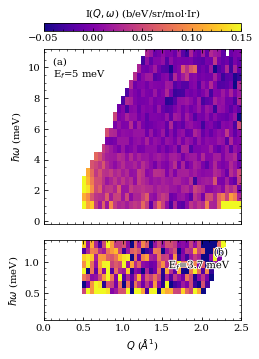

In [133]:
fig=plt.figure(constrained_layout=True,figsize=(3.54,5))

gs = matplotlib.gridspec.GridSpec(3,2,figure=fig)

#Perform masking of low-Q and elastic lines
ws_macs_masked= mask_QE_box_MD(mtd['macs_5mag'],[0,5],[0,1.0])
ws_macs_masked= mask_QE_box_MD(ws_macs_masked,[0,0.5],[0,20.0])
ws_macs_masked = CloneWorkspace(ws_macs_masked,OutputWorkspace='macs_5mag_plot')
#ws_macs_masked = SmoothMD(ws_macs_masked,'Hat',WidthVector=3)

ws_macs3_masked= mask_QE_box_MD(mtd['macs_3p7mag'],[0,5],[0,0.3])
ws_macs3_masked= mask_QE_box_MD(ws_macs3_masked,[0,0.5],[0,2.0])
ws_macs3_masked= mask_QE_box_MD(ws_macs3_masked,[0,2.5],[0,0.5])

ws_macs3_masked = CloneWorkspace(ws_macs3_masked,OutputWorkspace='macs_3p7mag_plot')
ws_macs3_masked = SmoothMD(ws_macs3_masked,'Hat',WidthVector=1)
ax_5 = fig.add_subplot(gs[0:2,:],projection='mantid')
ax_5.pcolormesh(ws_macs_masked,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
ax_5.set_xlabel('')
ax_5.set_xticklabels([])
ax_5.set_ylabel('$\hbar\omega$ (meV)')
ax_5.text(0.05,0.95,'(a) \nE$_f$=5 meV',transform=ax_5.transAxes,verticalalignment='top',horizontalalignment='left')

#Add a colorbar
l,b,w,h=ax_5.get_position().bounds
cax = fig.add_axes([l,b+h+0.05,w,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/mol$\cdot$Ir)'
cbar = plt.colorbar(mesh,orientation='horizontal',cax=cax)
cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',verticalalignment='bottom')
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))

ax_3 = fig.add_subplot(gs[2,:],projection='mantid')
ax_3.pcolormesh(ws_macs3_masked,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
ax_3.set_xlabel('$Q$ ($\AA^{1}$)')
ax_3.set_ylabel('$\hbar\omega$ (meV)')
txt3=ax_3.text(0.95,0.9,'(b) \nE$_f$=3.7 meV',transform=ax_3.transAxes,verticalalignment='top',horizontalalignment='right')
txt3.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Make consistent Q dimensions between the different Ef's
qlim=[0,2.5]
ax_5.set_xlim(qlim[0],qlim[1])
ax_3.set_xlim(qlim[0],qlim[1])


fig.savefig('DLIO_MACS_scattering.pdf',bbox_inches='tight',dpi=300)

## Factorization of MACS data here

fit A0.0030481728840169916
fit B5.17521689293501
fit C0.5360349598319233


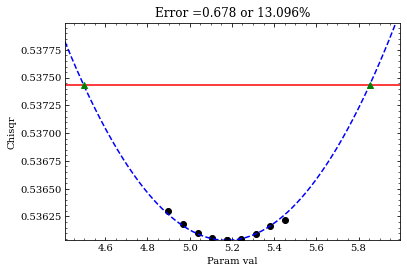

[                                        ]  1/48 (  2%) 47 to go

fit A0.002867633079773771
fit B3.6693993105441143
fit C0.5360349416674861


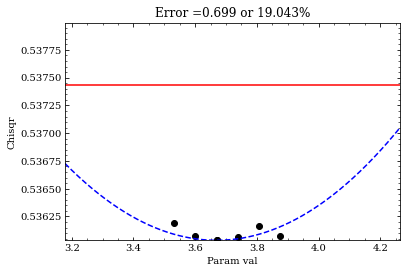

[=                                       ]  2/48 (  4%) 46 to go

fit A0.0035238201054765676
fit B2.716998482130609
fit C0.5360348565018705


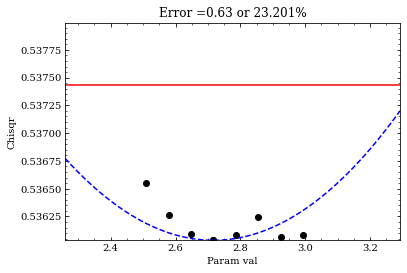

[==                                      ]  3/48 (  6%) 45 to go

fit A0.013483597846771528
fit B1.6159175999787951
fit C0.536034849411209


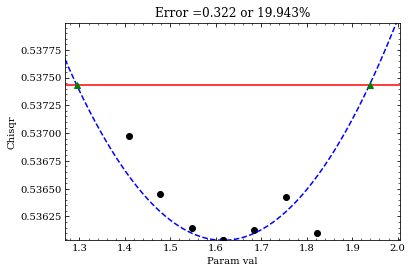

[===                                     ]  4/48 (  8%) 44 to go

fit A0.006913694378162392
fit B1.760465755656933
fit C0.536034818687528


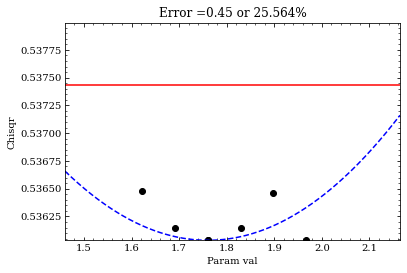

[====                                    ]  5/48 ( 10%) 43 to go

fit A0.008957629872187714
fit B1.383017921376354
fit C0.5360348109006784


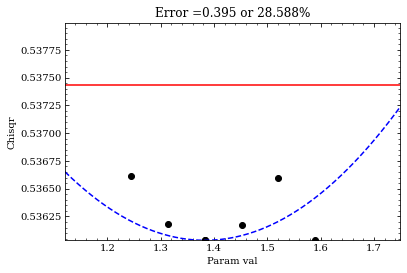

[=====                                   ]  6/48 ( 12%) 42 to go

fit A0.010204015630431556
fit B1.098279497618238
fit C0.5360348132522323


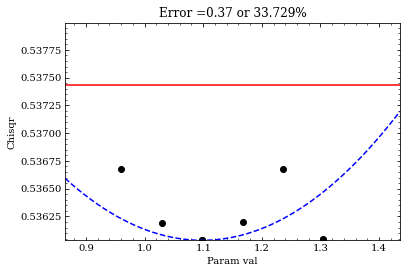

[=====                                   ]  7/48 ( 14%) 41 to go

fit A0.010349128752384045
fit B1.1407762127130021
fit C0.5360348159692385


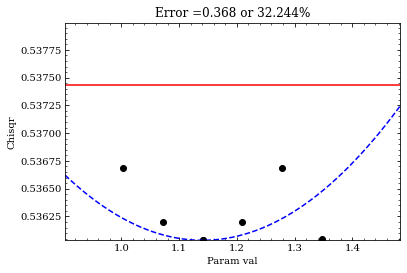

[======                                  ]  8/48 ( 16%) 40 to go

fit A0.013491713606644645
fit B0.9647091039831601
fit C0.5360348261146926


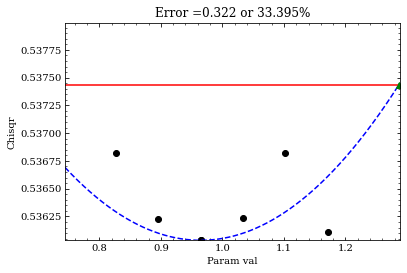

[=======                                 ]  9/48 ( 18%) 39 to go

fit A0.0004264253616679268
fit B1.2455502073822278
fit C0.5360348350397303


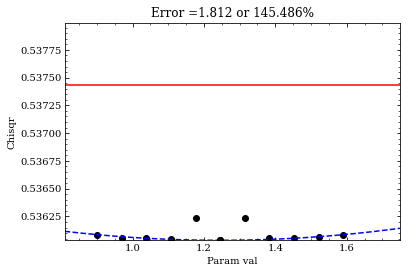

[========                                ] 10/48 ( 20%) 38 to go

fit A0.013212443019218128
fit B0.9396382403542731
fit C0.536034809640538


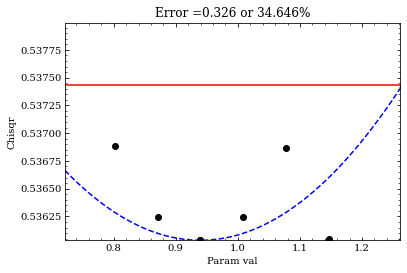

[=========                               ] 11/48 ( 22%) 37 to go

fit A0.023951883743084323
fit B0.79228993702361
fit C0.5360348216254361


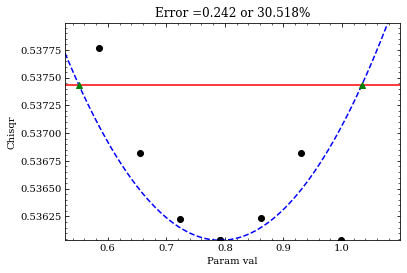

[==========                              ] 12/48 ( 25%) 36 to go

fit A0.0071623923532141654
fit B0.9803503013929643
fit C0.5360348096994569


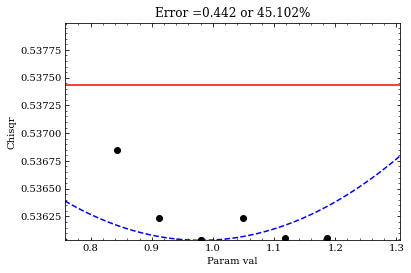

[==========                              ] 13/48 ( 27%) 35 to go

fit A0.02762424464312234
fit B0.7294377322339283
fit C0.5360348207480073


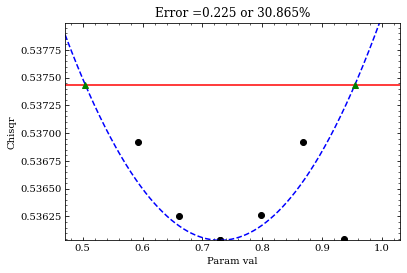

[===========                             ] 14/48 ( 29%) 34 to go

fit A0.0013945344934792466
fit B1.114708503896589
fit C0.5360348429000068


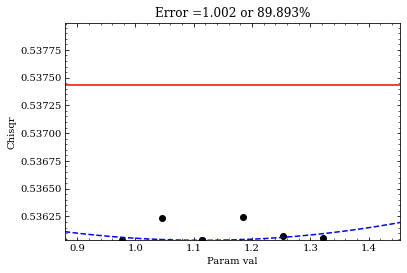

[============                            ] 15/48 ( 31%) 33 to go

fit A0.0004048533216313404
fit B1.0412195388245524
fit C0.5360348834030039


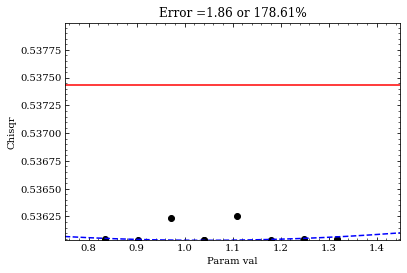

[=============                           ] 16/48 ( 33%) 32 to go

fit A0.02224819862448654
fit B0.7886684057435638
fit C0.5360348856497509


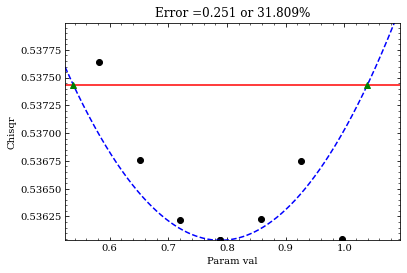

[==============                          ] 17/48 ( 35%) 31 to go

fit A0.02530415642970052
fit B0.474680753026878
fit C0.536034813467698


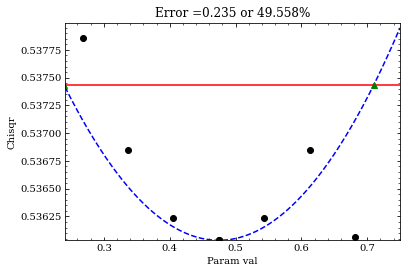

[===============                         ] 18/48 ( 37%) 30 to go

fit A0.022483845185022514
fit B0.5645275709980481
fit C0.5360348219781108


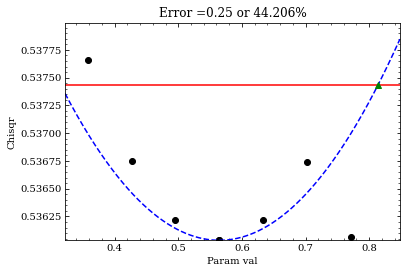

[===============                         ] 19/48 ( 39%) 29 to go

fit A0.0200292783889601
fit B0.8492285385610857
fit C0.5360348416166948


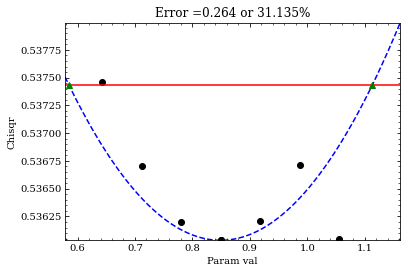

[================                        ] 20/48 ( 41%) 28 to go

fit A0.00884411559519566
fit B0.7726891588952716
fit C0.53603486502497


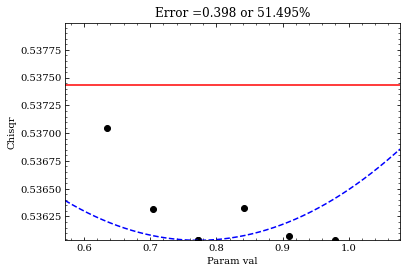

[=================                       ] 21/48 ( 43%) 27 to go

fit A0.02779704486716533
fit B0.33840862346923384
fit C0.5360348422912253


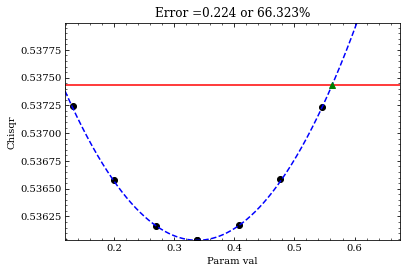

[==================                      ] 22/48 ( 45%) 26 to go

fit A0.025967754957498927
fit B0.4487895497076866
fit C0.5360348104092933


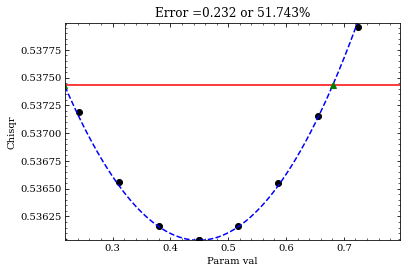

[===================                     ] 23/48 ( 47%) 25 to go

fit A0.025960512717682693
fit B0.5500639053476015
fit C0.5360348087502198


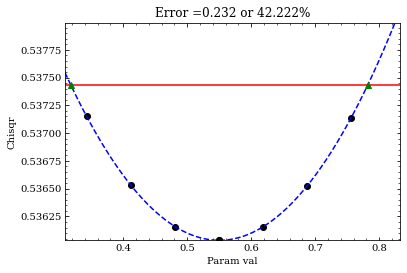

[====================                    ] 24/48 ( 50%) 24 to go

fit A0.025756502124585735
fit B0.4734033798240219
fit C0.5360348085448867


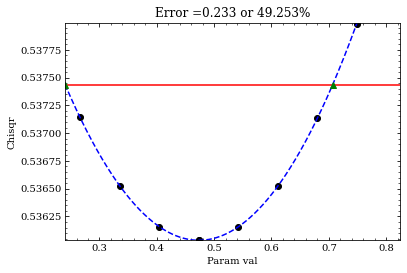

[====================                    ] 25/48 ( 52%) 23 to go

fit A0.02194318098172977
fit B0.5271700144926543
fit C0.5360348083891106


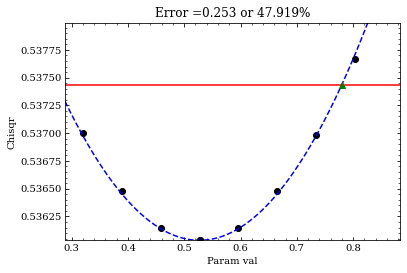

[=====================                   ] 26/48 ( 54%) 22 to go

fit A0.021843083359111223
fit B0.5437276054377105
fit C0.536034809139474


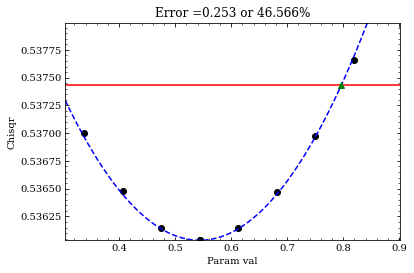

[======================                  ] 27/48 ( 56%) 21 to go

fit A0.020517807455557507
fit B0.518363033999423
fit C0.5360348090020666


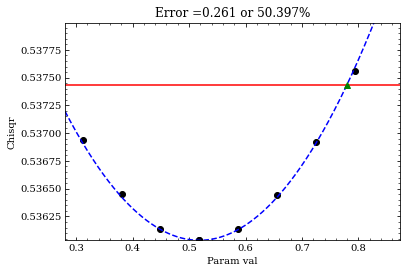

[=======================                 ] 28/48 ( 58%) 20 to go

fit A0.020892883245618984
fit B0.6958799292268469
fit C0.5360348087097739


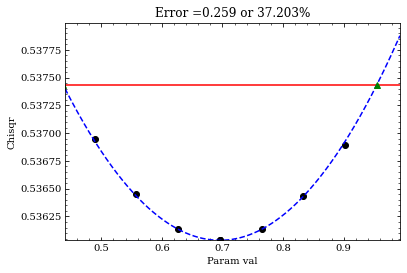

[========================                ] 29/48 ( 60%) 19 to go

fit A0.023367531369459037
fit B0.5915720907543909
fit C0.5360348186418498


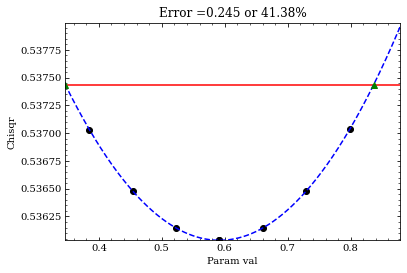

[=========================               ] 30/48 ( 62%) 18 to go

fit A1.4717545440274058
fit B0.03649428733073232
fit C0.5360348248458575


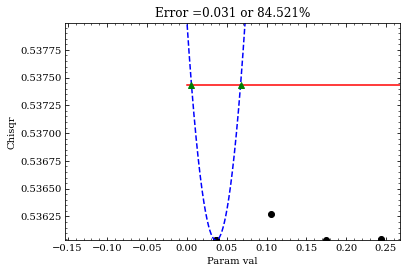

[=========================               ] 31/48 ( 64%) 17 to go

fit A111.69378013239715
fit B0.027370522775116868
fit C0.5360348440426114


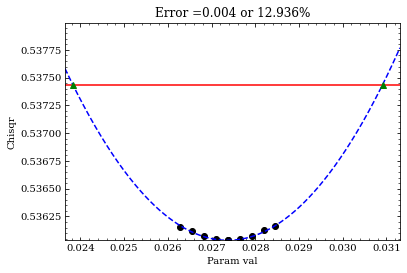

[==========================              ] 32/48 ( 66%) 16 to go

fit A88.575454688557
fit B0.03481640405001585
fit C0.5360348169222103


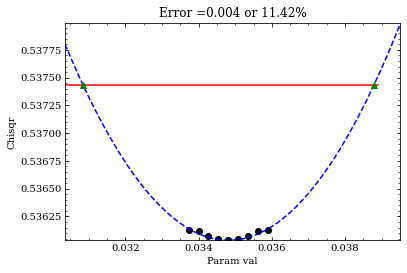

[===========================             ] 33/48 ( 68%) 15 to go

fit A150.66817111156652
fit B0.029510342809938583
fit C0.5360348096835573


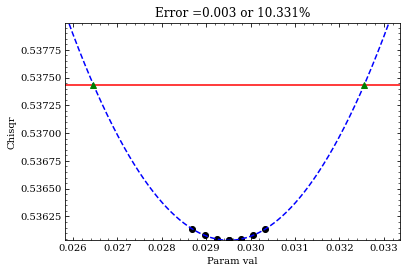

[============================            ] 34/48 ( 70%) 14 to go

fit A115.95755737406097
fit B0.02932324394910113
fit C0.5360348094569606


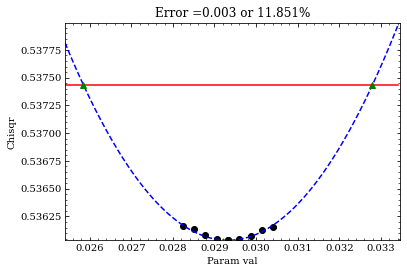

[=============================           ] 35/48 ( 72%) 13 to go

fit A132.34448815733847
fit B0.022458250724888495
fit C0.5360348193889876


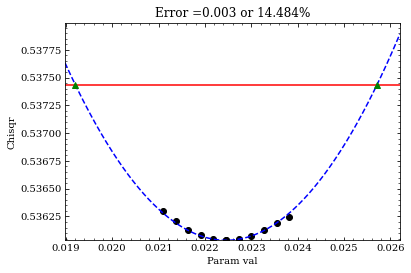

[==============================          ] 36/48 ( 75%) 12 to go

fit A168.90587351090304
fit B0.022960890337736073
fit C0.5360348585916483


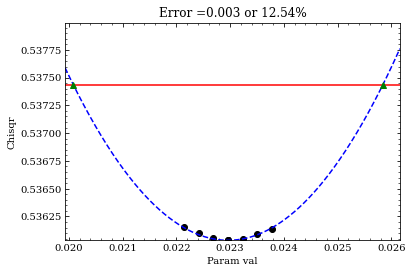

[==============================          ] 37/48 ( 77%) 11 to go

fit A146.38682486951484
fit B0.006917993556828428
fit C0.5360348137734549


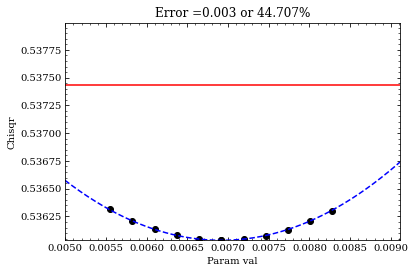

[===============================         ] 38/48 ( 79%) 10 to go

fit A128.24987286308115
fit B0.007883328422545466
fit C0.5360348102614476


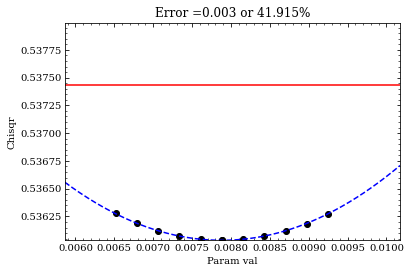

[================================        ] 39/48 ( 81%)  9 to go

fit A120.74766292140961
fit B0.01120277670498826
fit C0.5360348168648961


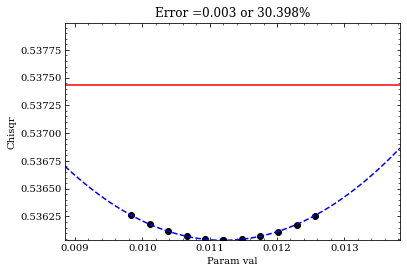

[=================================       ] 40/48 ( 83%)  8 to go

fit A131.66085295357806
fit B0.005132599662071691
fit C0.5360348149324508


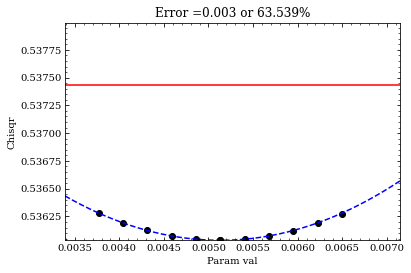

[==================================      ] 41/48 ( 85%)  7 to go

fit A126.66501387158804
fit B0.002443647284203543
fit C0.5360348098784279


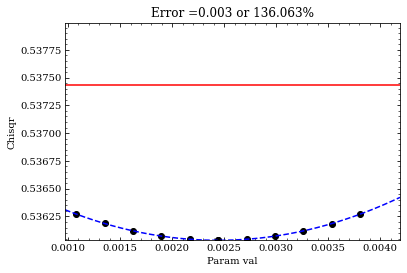

[===================================     ] 42/48 ( 87%)  6 to go

fit A144.46204528113586
fit B0.0
fit C0.5360166432073611


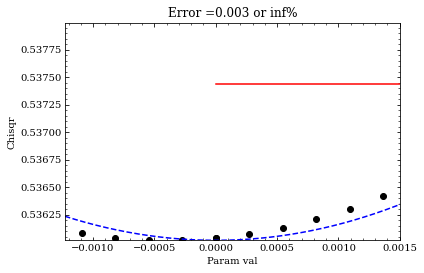

[===================================     ] 43/48 ( 89%)  5 to go

fit A121.14142035651561
fit B0.0025462367319681878
fit C0.5360348112307947


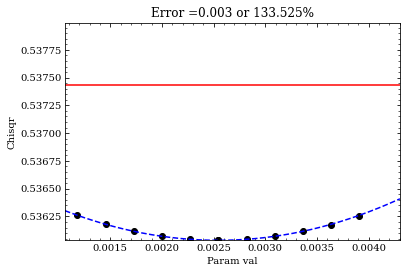

[====================================    ] 44/48 ( 91%)  4 to go

fit A484.7328543523773
fit B0.0
fit C0.535946704062285


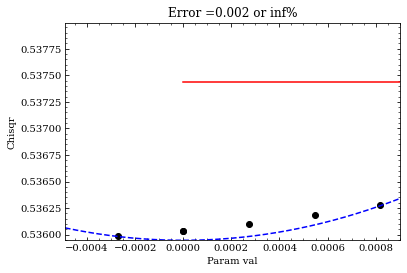

[=====================================   ] 45/48 ( 93%)  3 to go

fit A594.7802807393263
fit B0.0
fit C0.5359216114305413


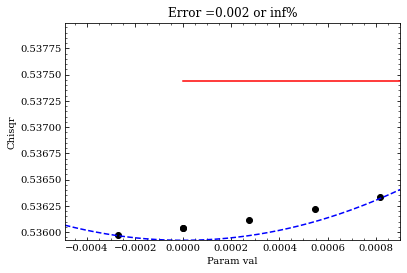

[======================================  ] 46/48 ( 95%)  2 to go

fit A53.04166964013881
fit B0.0040943219425508826
fit C0.5360348095391237


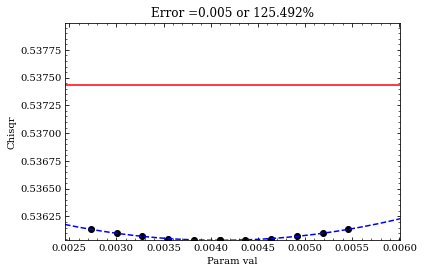

[======================================= ] 47/48 ( 97%)  1 to go

fit A33.32939851395179
fit B0.0024943725229122915
fit C0.5360348147387738


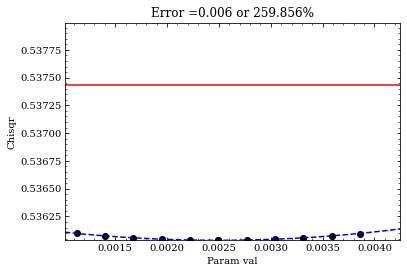

[========================================] 48/48 (100%)  0 to go

fit A0.0037570934643713135
fit B1.71557814867528
fit C0.4228744158028964


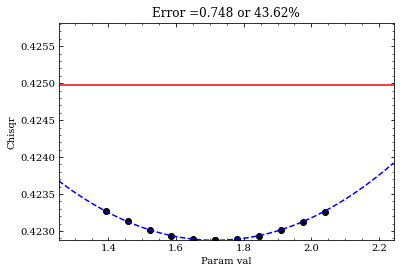

[=                                       ]  1/38 (  2%) 37 to go

fit A0.006097819960924932
fit B1.811864094870631
fit C0.42287443032227434


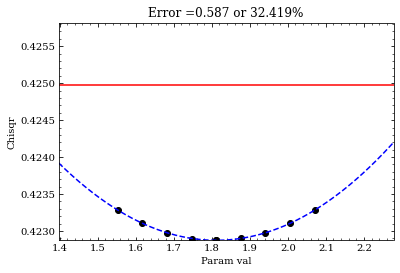

[==                                      ]  2/38 (  5%) 36 to go

fit A0.00917461154692497
fit B1.6767947545450652
fit C0.4228744123568653


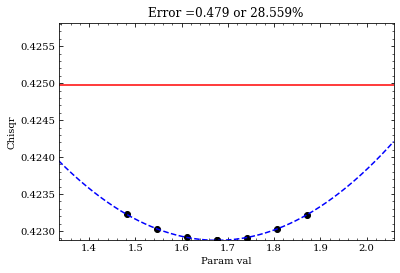

[===                                     ]  3/38 (  7%) 35 to go

fit A0.010328178314319455
fit B0.9876113856044015
fit C0.4228744099185712


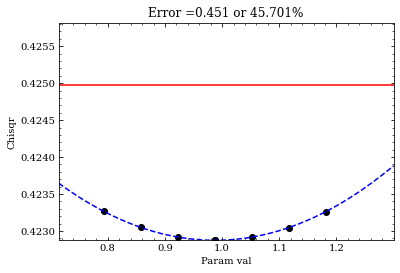

[====                                    ]  4/38 ( 10%) 34 to go

fit A0.0031101655872731162
fit B1.646924883410669
fit C0.42287440994112113


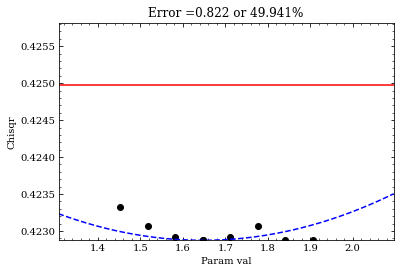

[=====                                   ]  5/38 ( 13%) 33 to go

fit A0.003516412324919205
fit B1.4943541879269835
fit C0.42287441660982916


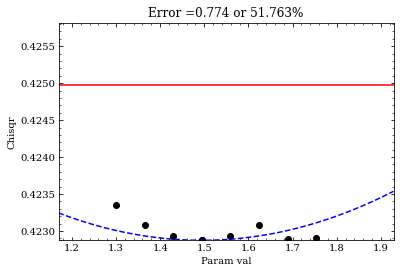

[======                                  ]  6/38 ( 15%) 32 to go

fit A0.0023018407574013867
fit B2.67896742408272
fit C0.4228744158171237


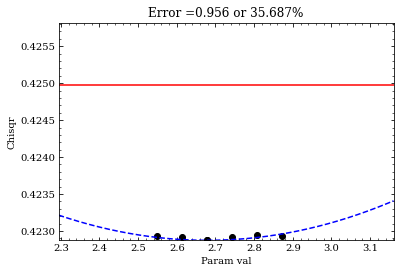

[=======                                 ]  7/38 ( 18%) 31 to go

fit A0.012958990661459176
fit B1.004969181695312
fit C0.42287440989669683


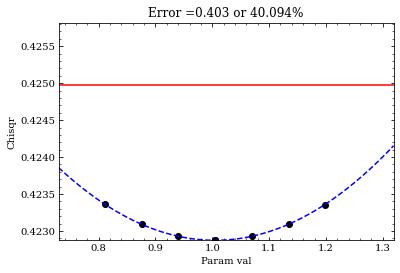

[========                                ]  8/38 ( 21%) 30 to go

fit A0.012647981399405213
fit B0.9678532933624414
fit C0.4228744114911071


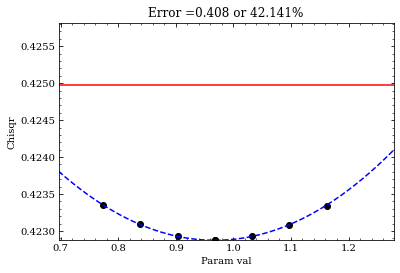

[=========                               ]  9/38 ( 23%) 29 to go

fit A0.0034246706916054876
fit B1.4020149806866087
fit C0.4228744101876499


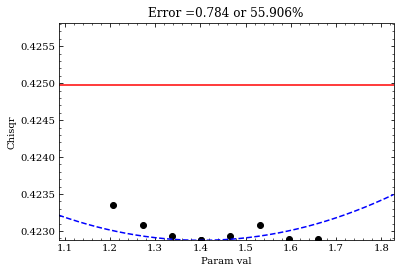

[==========                              ] 10/38 ( 26%) 28 to go

fit A0.011434874625084104
fit B0.9768625178596378
fit C0.4228744145209317


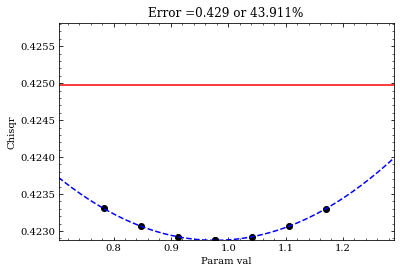

[===========                             ] 11/38 ( 28%) 27 to go

fit A0.002996993862727962
fit B1.5497217959674563
fit C0.4228744107719556


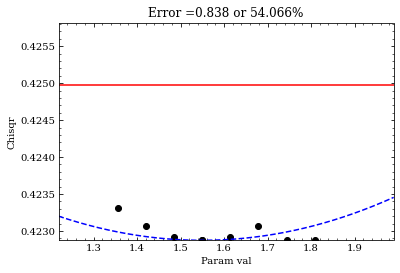

[============                            ] 12/38 ( 31%) 26 to go

fit A0.01244123185200277
fit B-0.5422809565409531
fit C0.4228744113289455


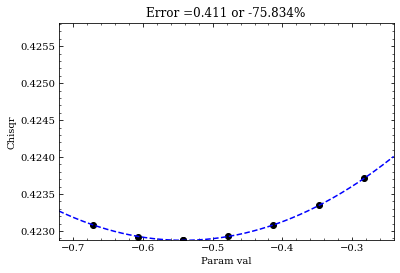

[=============                           ] 13/38 ( 34%) 25 to go

fit A0.0033716809310400343
fit B1.4598842160637797
fit C0.42287441111796514


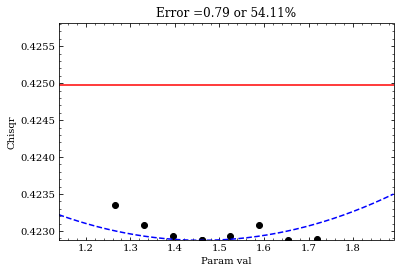

[==============                          ] 14/38 ( 36%) 24 to go

fit A0.004186611885001339
fit B1.2032897416910542
fit C0.422874417664728


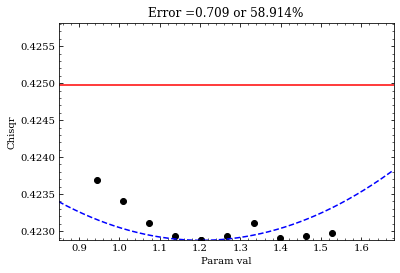

[===============                         ] 15/38 ( 39%) 23 to go

fit A0.014709672029550319
fit B0.7016286031665651
fit C0.4228744141609004


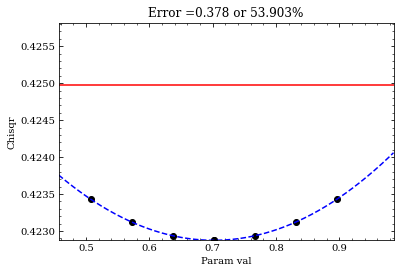

[================                        ] 16/38 ( 42%) 22 to go

fit A0.015733712744740516
fit B0.5712249857944612
fit C0.422874414448374


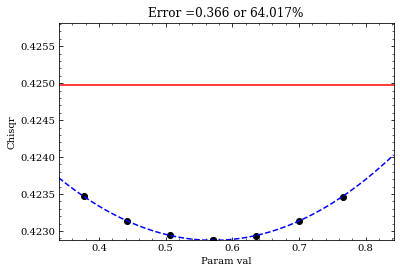

[=================                       ] 17/38 ( 44%) 21 to go

fit A0.013910166414597832
fit B0.17056619000718343
fit C0.42287441648370316


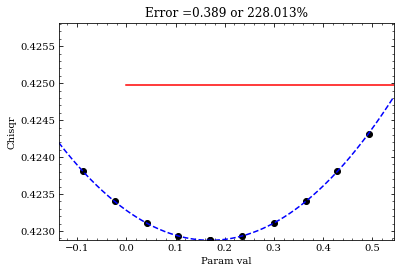

[==================                      ] 18/38 ( 47%) 20 to go

fit A0.012886137527332137
fit B1.0015922256275716
fit C0.4228744102801592


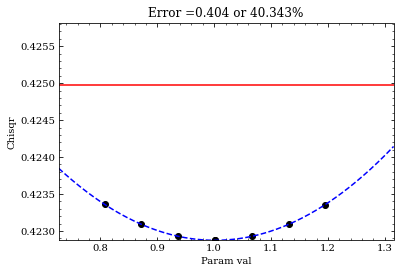

[====================                    ] 19/38 ( 50%) 19 to go

fit A0.010870474086114745
fit B0.7326770849592483
fit C0.4228744192996818


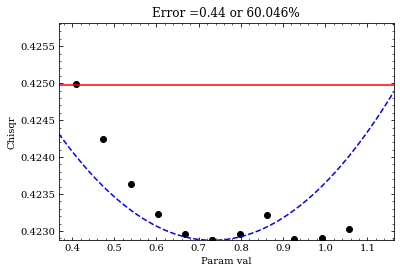

[=====================                   ] 20/38 ( 52%) 18 to go

fit A0.012409482017771135
fit B0.3996705563468101
fit C0.42287442549213616


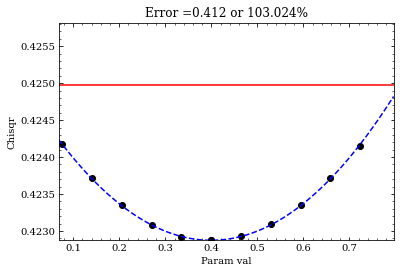

[======================                  ] 21/38 ( 55%) 17 to go

fit A0.003222280443463987
fit B1.3719935411668183
fit C0.42287442384080803


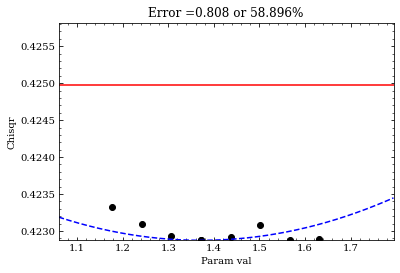

[=======================                 ] 22/38 ( 57%) 16 to go

fit A0.01316641303647016
fit B0.6309430934774223
fit C0.42287441408416987


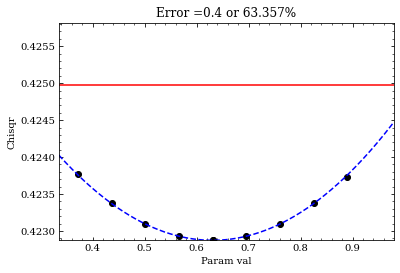

[========================                ] 23/38 ( 60%) 15 to go

fit A0.01469924360303845
fit B0.8623666982806154
fit C0.42287441208114196


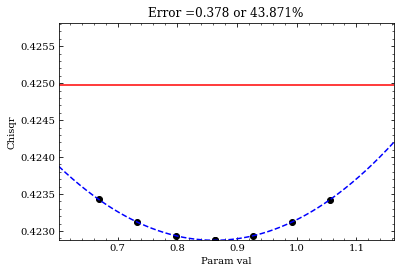

[=========================               ] 24/38 ( 63%) 14 to go

fit A0.012203070305672076
fit B0.6540755241092496
fit C0.42287440989512753


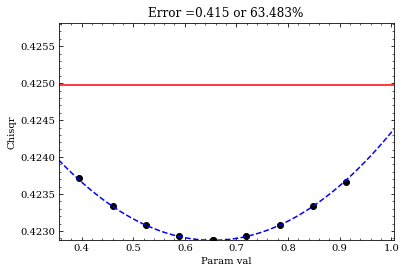

[==========================              ] 25/38 ( 65%) 13 to go

fit A0.011897182047095115
fit B0.46255342649073167
fit C0.4228744156546751


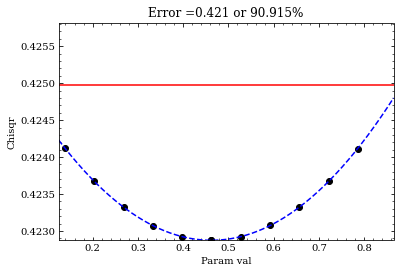

[===========================             ] 26/38 ( 68%) 12 to go

fit A0.009376288943236421
fit B0.42321519598637525
fit C0.422874416389199


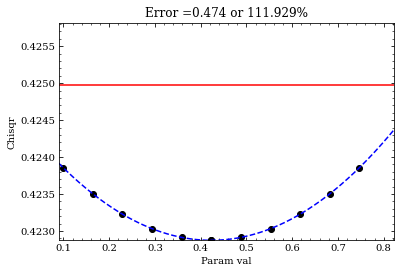

[============================            ] 27/38 ( 71%) 11 to go

fit A0.009125760866761628
fit B0.8027646583370117
fit C0.4228744114931755


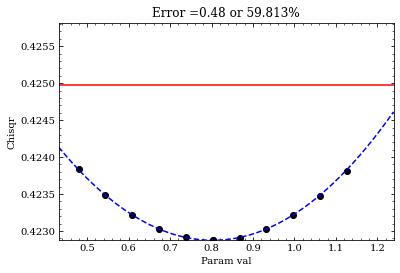

[=============================           ] 28/38 ( 73%) 10 to go

fit A0.005369298411858711
fit B1.1437372888499078
fit C0.4228744099244391


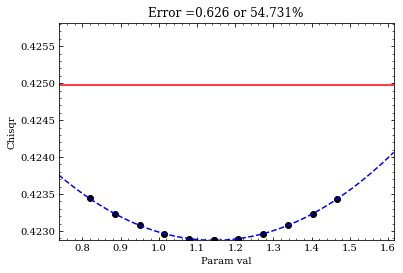

[==============================          ] 29/38 ( 76%)  9 to go

fit A0.005519984463133101
fit B0.61178866332632
fit C0.42287440995665987


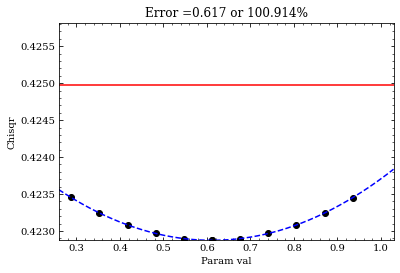

[===============================         ] 30/38 ( 78%)  8 to go

fit A0.8651904022140667
fit B0.08951023040336632
fit C0.42287441647479596


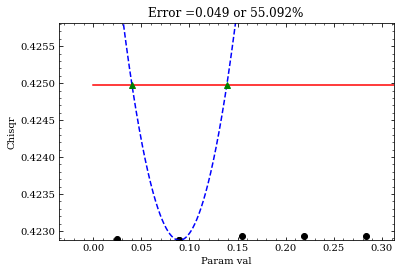

[================================        ] 31/38 ( 81%)  7 to go

fit A14.134805251189551
fit B0.035241406693450994
fit C0.42287441232173023


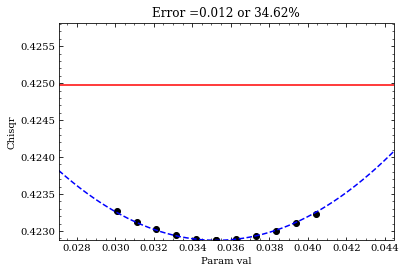

[=================================       ] 32/38 ( 84%)  6 to go

fit A14.96586067502988
fit B0.04389476998847197
fit C0.42287440991095954


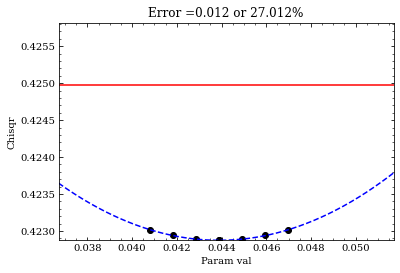

[==================================      ] 33/38 ( 86%)  5 to go

fit A15.356869022409656
fit B0.045415635430970935
fit C0.4228744186276809


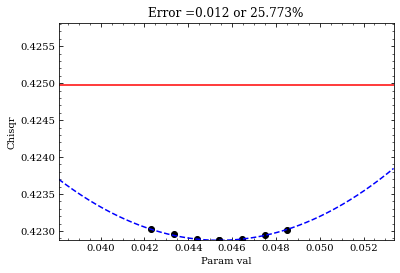

[===================================     ] 34/38 ( 89%)  4 to go

fit A10.146125671720826
fit B0.06173245988278264
fit C0.42287441221212785


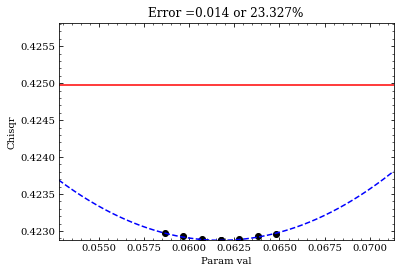

[====================================    ] 35/38 ( 92%)  3 to go

fit A3.6852626313267365
fit B0.05690229339742192
fit C0.42287440991363473


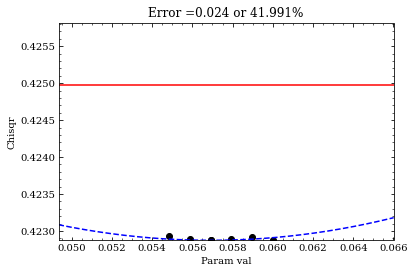

[=====================================   ] 36/38 ( 94%)  2 to go

fit A15.98506542392493
fit B0.035149211705431505
fit C0.4228744100341752


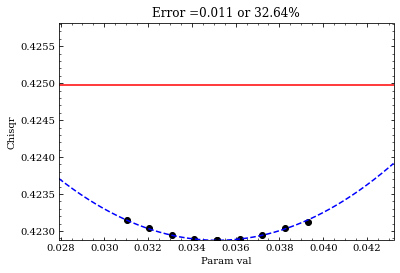

[======================================  ] 37/38 ( 97%)  1 to go

fit A6.122443249783821
fit B0.04565439551294492
fit C0.4228744107765874


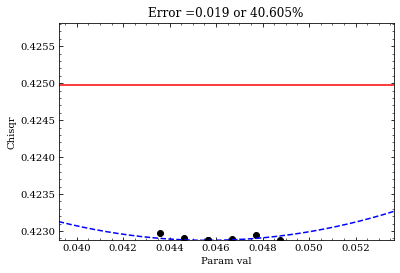

[========================================] 38/38 (100%)  0 to go

In [134]:
macs5_factor_fname='MACS5_fact.npy'
macs5factor=MDfactorization(mtd['macs_5mag'],mag_ion='Ir4',\
                                     q_lim=[0.5,2],e_lim=[1.0,10],Ei=13.7,\
                                     twoThetaMin=False,plot_result=False,method='powell',fname=macs5_factor_fname,\
                                     overwrite_prev=True,allow_neg_E=False,g_factor=2.0,fast_mode=False)
macs3_factor_fname='MACS3p7_fact.npy'
macs3factor=MDfactorization(mtd['macs_3p7mag'],mag_ion='Ir4',\
                                     q_lim=[0.5,2],e_lim=[0.5,1.3],Ei=5.0,\
                                     twoThetaMin=False,plot_result=False,method='powell',fname=macs3_factor_fname,\
                                     overwrite_prev=True,allow_neg_E=False,g_factor=2.0,fast_mode=False)



Moment = 1.732 (0.145)


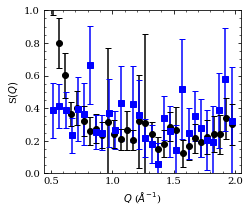

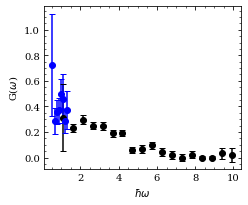

In [135]:
#Quick plots checking the factorizations, recalling that the spectral weight integrates to one
scale3=0.3

fig,ax=plt.subplots(1,1,figsize=(3.54,3))
ax.errorbar(macs5factor[0],macs5factor[1],macs5factor[2],color='k',marker='o',ls=' ',capsize=3)
ax.errorbar(macs3factor[0],macs3factor[1]/scale3,macs3factor[2]/scale3,color='b',marker='s',ls=' ',capsize=3)
ax.set_xlabel('$Q$ ($\AA^{-1}$)')
ax.set_ylabel('S$(Q)$')
ax.set_ylim(0,1)

fig,ax=plt.subplots(1,1,figsize=(3.54,3))
ax.errorbar(macs5factor[3],macs5factor[4],macs5factor[5],color='k',marker='o',ls=' ',capsize=3)
ax.errorbar(macs3factor[3],macs3factor[4]*scale3,macs3factor[5]*scale3,color='b',marker='o',ls=' ',capsize=3)
ax.set_ylabel('G($\omega$)')
ax.set_xlabel('$\hbar\omega$')

#Overall moment suggested by this factorization:
norm_err = 0.3# as a percent error
frac_err = norm_err#*macs5factor[1]/macs5factor[2]
momentsqr = 3.0*(2.0**2)*np.trapz(macs5factor[1]*macs5factor[0]**2,x=macs5factor[0])/\
            np.trapz(macs5factor[0]**2,x=macs5factor[0])
moment = np.sqrt(momentsqr)

errnum = get_trapz_err(macs5factor[0],macs5factor[1]*macs5factor[0]**2,\
                       macs5factor[1]*np.sqrt((macs5factor[2]/macs5factor[1])**2+frac_err**2)\
                       *macs5factor[0]**2)
momentsqr_err = 3.0*(2.0**2) * errnum/np.trapz(macs5factor[0]**2,x=macs5factor[0])
moment_err = (moment*momentsqr_err/momentsqr)/2.0
print(f"Moment = {moment:.3f} ({moment_err:.3f})")

## Plot of HYS measurements here

[0.15 0.45 0.75 1.05 1.35 1.65 1.95 2.25 2.55 2.85]
Int G(omega)=0.7399640021228


constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.


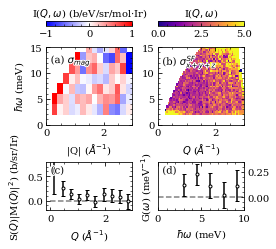

In [136]:
fig=plt.figure(constrained_layout=True,figsize=(3.54,3.0))

gs = matplotlib.gridspec.GridSpec(12,2,figure=fig,hspace=1.5,wspace=0.3)

ax_mag_sqe = fig.add_subplot(gs[0:6,0],projection='mantid')
ax_sf_sqe = fig.add_subplot(gs[0:6,1],projection='mantid')

ax_sq = fig.add_subplot(gs[8:,0])
ax_ge = fig.add_subplot(gs[8:,1])

#Add low energy masking
ws_hys_masked= mask_QE_box_MD(mtd['hys_mag'],[0,5],[0,2])
ws_hys_masked = CloneWorkspace(ws_hys_masked,OutputWorkspace='hys_mag_plot')
ws_hys_maskedSF= mask_QE_box_MD(mtd['hys_SF'],[0,5],[0,2])
ws_hys_maskedSF = CloneWorkspace(ws_hys_maskedSF,OutputWorkspace='hys_SF_plot')

mesh_mag = ax_mag_sqe.pcolormesh(mtd['hys_mag_plot'],vmin=-1,vmax=1,cmap='bwr',rasterized=True)
ax_mag_sqe.set_xlim(0,3)
ax_mag_sqe.set_ylim(0,15)
txta=ax_sf_sqe.text(0.05,0.92,'(a) $\sigma_{mag}$',transform=ax_mag_sqe.transAxes,horizontalalignment='left',verticalalignment='top')
txta.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])
#Add a colorbar to magnetic 
l,b,w,h=ax_mag_sqe.get_position().bounds
cax = fig.add_axes([l,b+h+0.1,w,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/mol$\cdot$Ir)'
cbar = plt.colorbar(mesh_mag,orientation='horizontal',cax=cax)
cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',verticalalignment='bottom')
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))

ax_mag_sqe.set_ylabel('$\hbar\omega$ (meV)')

mesh_sf = ax_sf_sqe.pcolormesh(mtd['hys_SF_plot'],vmin=0,vmax=5,cmap=cmap,rasterized=True)
ax_sf_sqe.set_ylabel('')
ax_sf_sqe.set_xlim(0,3)
ax_sf_sqe.set_ylim(0,15)
txtb=ax_sf_sqe.text(0.05,0.92,'(b) $\sigma_{x+y+z}^{SF}$',transform=ax_sf_sqe.transAxes,horizontalalignment='left',verticalalignment='top')
txtb.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Add a colorbar for SF
l,b,w,h=ax_sf_sqe.get_position().bounds
cax = fig.add_axes([l,b+h+0.1,w,0.02])
labelstr='I($Q,\omega$)'
cbar = plt.colorbar(mesh_sf,orientation='horizontal',cax=cax)
cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',verticalalignment='bottom')
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))


#Cuts in Q, energy, are done on the analysis cluster - event files too large for personal machine. 
# Scripts for cluster available upon request. 
qcutmag = np.genfromtxt('../Part 5 - HYS Scattering/cut_data/sq_mag_cut_.txt',skip_header=2)
ecutmag = np.genfromtxt('../Part 5 - HYS Scattering/cut_data/ge_mag_cut.txt',skip_header=2)
#For some reason MANTID 
print(qcutmag[:,2])
ax_sq.errorbar(qcutmag[:,2],qcutmag[:,0],qcutmag[:,1],color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=2,ms=3)

ax_ge.errorbar(ecutmag[:,2],ecutmag[:,0],ecutmag[:,1],color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=2,ms=3)
ax_ge.set_xlim(0,10)
ax_sq.set_ylim(-0.2,0.8)
ax_sq.plot(np.linspace(0,np.nanmax(qcutmag[:,2]),1000),np.zeros(1000),'k--',alpha=0.5)
ax_ge.plot(np.linspace(0,10,1000),np.zeros(1000),'k--',alpha=0.5)
ax_ge.yaxis.tick_right()

ax_sq.set_xlabel('$Q$ ($\AA^{-1}$)')
ax_sf_sqe.set_xlabel('$Q$ ($\AA^{-1}$)')

ax_ge.set_xlabel('$\hbar\omega$ (meV)')

ax_sq.set_ylabel('S($Q$)|M($Q$)|$^2$) (b/sr/Ir)')
ax_ge.set_ylabel('G($\omega$) (meV$^{-1}$)')


txtc=ax_sq.text(0.05,0.9,'(c)',transform=ax_sq.transAxes,horizontalalignment='left',verticalalignment='top')
txtc.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

txtd=ax_ge.text(0.05,0.9,'(d)',transform=ax_ge.transAxes,horizontalalignment='left',verticalalignment='top')
txtd.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

integral = np.trapz(ecutmag[:,0],x=ecutmag[:,2])
print(f"Int G(omega)={integral}")

fig.savefig('HYS_scattering.pdf',bbox_inches='tight',dpi=300)

## HYS factorizations, or attempts. 

This is extremely touchy due to poor statistics.

Gw integral
0.009777216754871459
Evaluating Uncertainty for param_0
Param param_0 does not affect chisqr.
Param param_0 does not affect chisqr.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


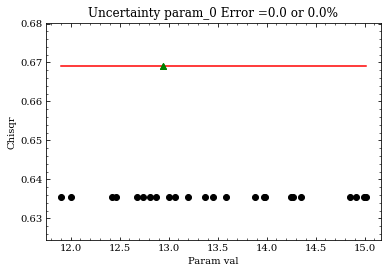

[===                                     ]  1/13 (  7%) 12 to go

Evaluating Uncertainty for param_1
Enable show_plots=True and check quality of initial fit.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


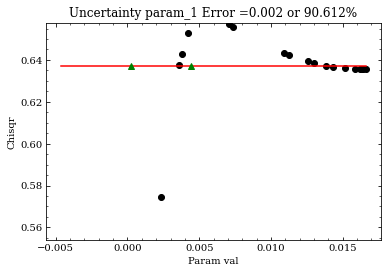

[======                                  ]  2/13 ( 15%) 11 to go

Evaluating Uncertainty for param_2


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Enable show_plots=True and check quality of initial fit.


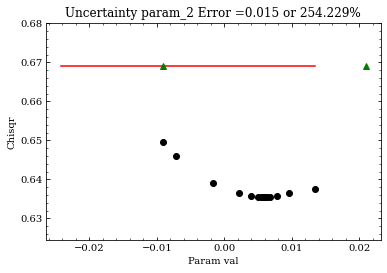

[=========                               ]  3/13 ( 23%) 10 to go

Evaluating Uncertainty for param_3


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Enable show_plots=True and check quality of initial fit.


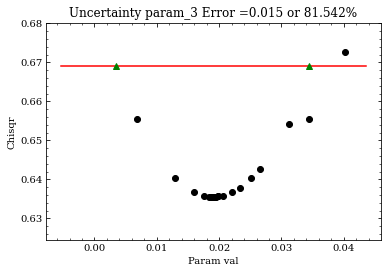

[============                            ]  4/13 ( 30%)  9 to go

Evaluating Uncertainty for param_4


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Enable show_plots=True and check quality of initial fit.


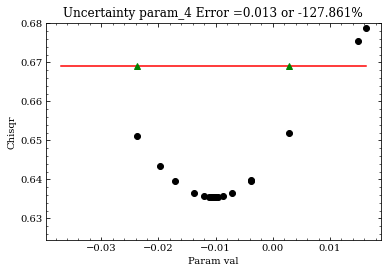

[===============                         ]  5/13 ( 38%)  8 to go

Evaluating Uncertainty for param_5
Enable show_plots=True and check quality of initial fit.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


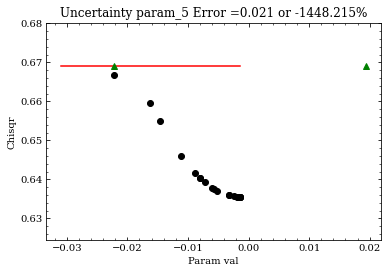

[==================                      ]  6/13 ( 46%)  7 to go

Evaluating Uncertainty for param_6


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Insufficient number of points under max chisqr. Recursively iterating.
Good points: 19/20
Enable show_plots=True and check quality of initial fit.


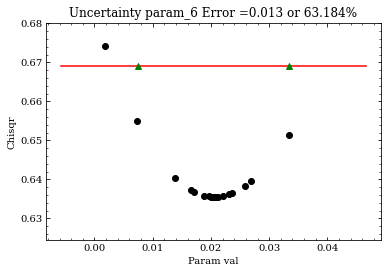

[=====================                   ]  7/13 ( 53%)  6 to go

Evaluating Uncertainty for param_7
Enable show_plots=True and check quality of initial fit.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


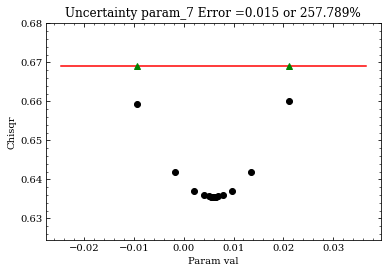

[========================                ]  8/13 ( 61%)  5 to go

Evaluating Uncertainty for param_8
Enable show_plots=True and check quality of initial fit.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


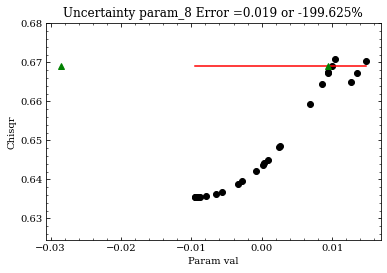

[===========================             ]  9/13 ( 69%)  4 to go

Evaluating Uncertainty for param_9


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Enable show_plots=True and check quality of initial fit.


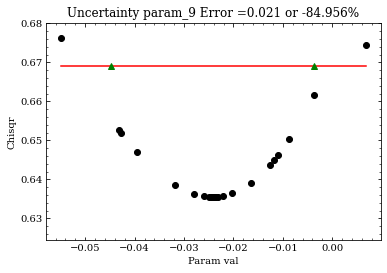

[==============================          ] 10/13 ( 76%)  3 to go

Evaluating Uncertainty for param_11
Param param_11 does not affect chisqr.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


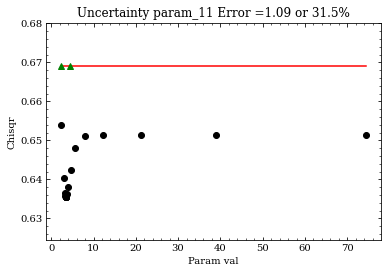

[=================================       ] 11/13 ( 84%)  2 to go

Evaluating Uncertainty for param_12


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


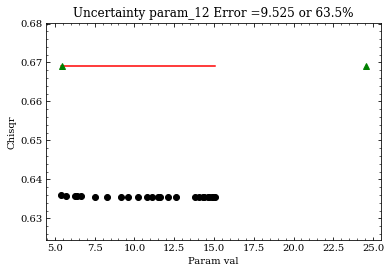

[====================================    ] 12/13 ( 92%)  1 to go

Evaluating Uncertainty for param_13
Param param_13 does not affect chisqr.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


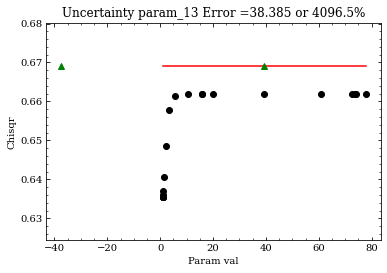

[========================================] 13/13 (100%)  0 to go

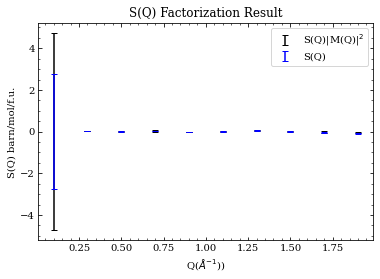

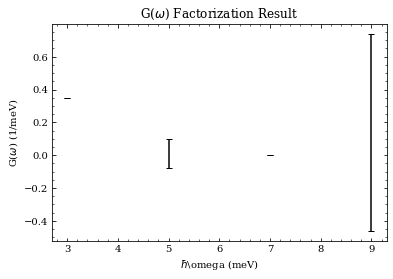

In [137]:
hys_mag_factorname='hys_magfactor.npy'

md_factor = mtd['hys_mag']/1.2e5
factor_hysmag = MDfactorizationv2(md_factor,mag_ion='Ir4',\
                                     q_lim=[0.0,2],e_lim=[2.0,10],Ei=20.0,\
                                     twoThetaMin=False,plot_result=True,method='powell',\
                                fname=hys_mag_factorname,\
                                     overwrite_prev=True,allow_neg_E=False,g_factor=2.0,fast_mode=False)

#Instead it is easier to just use the cuts with the appropriate normalizations. Fitting routine is not stable.
factor_hysmag_alt = [qcutmag[:,2]*integral,qcutmag[:,0]*integral,qcutmag[:,1]*integral,\
                     ecutmag[:,2]/integral,ecutmag[:,0]/integral,ecutmag[:,1]/integral]



Moment = 1.732 (0.504)


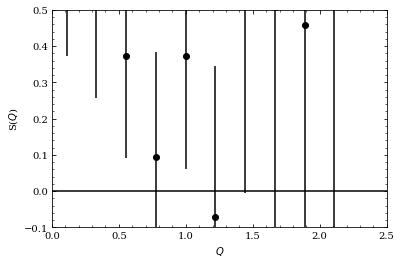

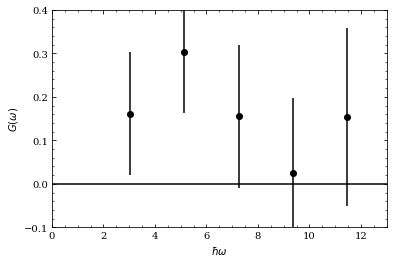

In [144]:
plt.figure()
#plt.errorbar(factor_hysmag[0],factor_hysmag[1],factor_hysmag[2])
qff,ff = get_MANTID_magFF(factor_hysmag_alt[0],mag_ion='Ir4')
magffsqr=1.0/ff
r0=0.5391
g=2.0
sq_alt = factor_hysmag_alt[1]*4.0/(r0**2 * g**2 * magffsqr)
sq_alt_err = factor_hysmag_alt[2]*4.0/(r0**2 * g**2 * magffsqr)

plt.errorbar(factor_hysmag_alt[0],sq_alt,sq_alt_err,marker='o',ls=' ',color='k')

plt.plot(np.linspace(0,3,1000),np.zeros(1000),'k-')
plt.ylim(-0.1,0.5)
plt.xlim(0,2.5)
plt.xlabel('$Q$')
plt.ylabel('S($Q$)')
plt.figure()
#plt.errorbar(factor_hysmag[3],factor_hysmag[4],factor_hysmag[5])
plt.errorbar(factor_hysmag_alt[3]-1,factor_hysmag_alt[4],factor_hysmag_alt[5],marker='o',ls=' ',color='k')
plt.plot(np.linspace(0,15,1000),np.zeros(1000),'k-')
plt.xlim(0,13)
plt.ylim(-0.1,0.4)
plt.xlabel('$\hbar\omega$')
plt.ylabel('$G(\omega)$')

#Overall moment suggested by this factorization:
norm_err = 0.3
frac_err = norm_err#*factor_hysmag_alt[2]/factor_hysmag_alt[1]
moment_frac = 1.0
momentsqr = 3.0*(2.0**2)*np.trapz(moment_frac*sq_alt*factor_hysmag_alt[0]**2,x=factor_hysmag_alt[0])/\
            np.trapz(factor_hysmag_alt[0]**2,x=factor_hysmag_alt[0])
moment = np.sqrt(momentsqr)
errnum = get_trapz_err(factor_hysmag_alt[0],sq_alt*factor_hysmag_alt[0]**2,\
                       sq_alt*np.sqrt((sq_alt/sq_alt_err)**2 + frac_err**2)*factor_hysmag_alt[0]**2)
momentsqr_err = 3.0*(2.0**2) * errnum/np.trapz(factor_hysmag_alt[0]**2,x=factor_hysmag_alt[0])
moment_err = (moment*momentsqr_err/momentsqr)/2.0
print(f"Moment = {moment:.3f} ({moment_err:.3f})")

## Finally, figure with factorizations + THz

OSError: [Errno 26] Text file busy: 'HLIO_factorizations_THz.pdf'

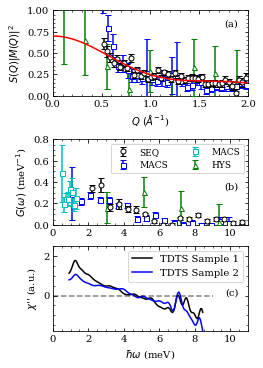

In [176]:
#THz imports 
thz_dir = "THz/"
thz_trans_main = np.genfromtxt(thz_dir+'Final_transmission_main_pellet.txt',skip_header=1)
temps_thz_trans_main = np.array([3.0,5.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,25.0,30.0,\
                                 40.0,50.0,70.0,100.0,125.0,300.0])
thz_trans2_main = np.genfromtxt(thz_dir+'Final_transmission_main_pellet_2.txt',skip_header=1)
temps_thz_trans2_main = np.array([3.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,50.0,70.0,100.0,125.0,150.0,175.0,\
                                 200.0,225.0,250.0,275.0,296.0])
thz_chi2_1 = np.genfromtxt(thz_dir+'Magnetic-susceptibility.txt',skip_header=1)
temps_thz_chi2_1 = np.array([14.0,12.0,10.0,10.0,8.0,5.0,3.0,14.0,12.0,10.0,10.0,8.0,5.0,3.0]) #Chi2 then chi2
thz_chi2_2 = np.genfromtxt(thz_dir+'Magnetic-susceptibility_2_ref25K.txt',skip_header=1)
temps_thz_chi2_2 = np.array([3.0,10.0,15.0,20.0,25.0,3.0,10.0,15.0,20.0,25.0]) #Chi1 then Chi2
thz_T_tempcut = np.genfromtxt(thz_dir +'transmission-temp-cuts_1.txt',skip_header=1)
freqs_thz_Ttempcut = np.array([0.41,0.45,0.50,0.55,0.60,0.70,0.75,0.80,0.85,0.90,\
                               0.41,0.45,0.50,0.55,0.60,0.70,0.75,0.80,0.85,0.90]) #Transmission frequency, then error
thz_T2_tempcut = np.genfromtxt(thz_dir +'transmission-temp-cuts_2.txt',skip_header=1)
freqs_thz_T2tempcut = np.array([0.35,0.41,0.45,0.55,0.60,0.70,0.75,0.80,0.85,0.90,\
                               0.35,0.41,0.45,0.55,0.60,0.70,0.75,0.80,0.85,0.90])
thz_T3_tempcut = np.genfromtxt(thz_dir+'transmission-temp-cuts_1_more_temp.txt',skip_header=1)
freqs_thz_T3tempcut = np.array([0.43,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85])

#First plot the THz spectra in the upper figure
THz_to_meV = 4.18
THz_3K_sample1 = thz_chi2_1[:,6]*1e3
THz_3K_E_sample1 = thz_chi2_1[:,0]*THz_to_meV
THz_3K_sample2 = thz_chi2_1[:,3]*1e3
THz_3K_E_sample2 = thz_chi2_1[:,0]*THz_to_meV

fig=plt.figure(constrained_layout=True,figsize=(3.54,5.0))

gs = matplotlib.gridspec.GridSpec(3,1,figure=fig,hspace=1.0,wspace=0.3)

sq_ax = fig.add_subplot(gs[0])
gw_ax = fig.add_subplot(gs[1])
thz_ax = fig.add_subplot(gs[2])

#Start with S(Q) factorizations, fit to model
# We want to plot the more closely observed quantity |F(Q)|^2 * S(Q)
# SEQ, MACS, HYS
seq_scale = 1.0
sq_ax.text(0.95,0.9,'(a)',transform=sq_ax.transAxes,horizontalalignment='right',\
           verticalalignment='top')
markersize=5
macs3scale=1.0/0.2
macs5scale=1.0/0.94

ffseq = 1.0/get_MANTID_magFF(qseq,'Ir4')[1]
sq_ax.errorbar(qseq,sqseq*seq_scale*ffseq,ffseq*sqerrseq*seq_scale,color='k',\
               marker='o',mfc='w',mec='k',ls=' ',capsize=3,zorder=10,ms=markersize)
ffmacs = 1.0/get_MANTID_magFF(macs5factor[0],'Ir4')[1]
sq_ax.errorbar(macs5factor[0],macs5factor[1]*ffmacs*macs5scale,macs5factor[2]*ffmacs*macs5scale,color='b',\
               marker='s',ls=' ',capsize=3,zorder=5,mfc='w',ms=markersize)
ffhys = 1.0/get_MANTID_magFF(factor_hysmag_alt[0],'Ir4')[1]
sq_ax.errorbar(factor_hysmag_alt[0],sq_alt*ffhys,sq_alt_err*ffhys,color='g',\
               marker='^',ls=' ',capsize=3,zorder=5,mfc='w',ms=markersize)
def modelq(q,A):
    return A*(1.0+np.sin(q*3.54)/(q*3.54))
qmodel = np.linspace(0,2.5,1000)
ffmodel=1.0/get_MANTID_magFF(qmodel,'Ir4')[1]
sq_ax.plot(qmodel,modelq(qmodel,0.35)*seq_scale*ffmodel,'r-',zorder=100)
#Now G(omega)

gw_ax.errorbar(eseq,geseq/seq_scale,geerrseq/seq_scale,color='k',marker='o',mfc='w',mec='k',ls=' ',\
               capsize=3,zorder=10,label='SEQ',ms=markersize)
gw_ax.errorbar(macs5factor[3],macs5factor[4]/macs5scale,macs5factor[5]/macs5scale,color='b',\
               marker='s',ls=' ',capsize=3,zorder=5,mfc='w',label='MACS',ms=markersize)
gw_ax.errorbar(macs3factor[3],macs3factor[4]/macs3scale,macs3factor[5]/macs3scale,color='c',\
               marker='s',ls=' ',capsize=3,zorder=5,mfc='w',label='MACS',ms=markersize)
gw_ax.errorbar(factor_hysmag_alt[3]-1,factor_hysmag_alt[4],factor_hysmag_alt[5],color='g',\
               marker='^',ls=' ',capsize=3,zorder=5,mfc='w',label='HYS',ms=markersize)
gw_ax.text(0.95,0.5,'(b)',transform=gw_ax.transAxes,horizontalalignment='right',\
           verticalalignment='top')
gw_ax.legend(fontsize=9,loc=1,ncol=2)
gw_ax.set_ylim(0,0.8)

sq_ax.set_ylim(0,1)
sq_ax.set_xlim(0,2.0)


thz_ax.plot(THz_3K_E_sample1,THz_3K_sample1,'k-',label='TDTS Sample 1')
thz_ax.plot(THz_3K_E_sample2,THz_3K_sample2,'b-',label='TDTS Sample 2')
thz_ax.plot(np.linspace(0,9,1000),np.zeros(1000),'k--',alpha=0.5)
thz_ax.set_ylabel('$\chi$\'\' (a.u.)')
thz_ax.text(0.95,0.5,'(c)',transform=thz_ax.transAxes,horizontalalignment='right',\
           verticalalignment='top')

#Have the G(w) and THz subplots share an x-axis 
thz_ax.sharex(gw_ax)
thz_ax.set_ylim(-1.8,2.5)
thz_ax.set_xlim(0,11)
thz_ax.legend()

#Axis labels
sq_ax.set_ylabel('$S(Q)|M(Q)|^2$')
sq_ax.set_xlabel(r'$Q$ $(\AA^{-1}$)')

gw_ax.set_ylabel('$G(\omega)$ (meV$^{-1}$)');
thz_ax.set_xlabel('$\hbar\omega$ (meV)')

fig.savefig('HLIO_factorizations_THz.pdf',bbox_inches='tight')

Integrated g(w)=1.00


<ErrorbarContainer object of 3 artists>

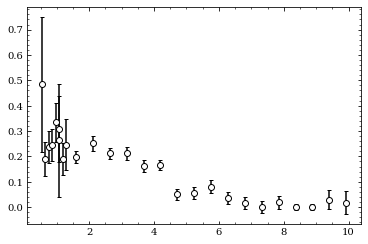

In [177]:
# The MACS data is assumed to cover the full spectral range, thus its G(omega) should integrate to one. 
frac3 = 0.2
frac5 = 0.85
e_all_macs = np.append(macs3factor[3],macs5factor[3])
ge_all_macs = np.append(macs3factor[4]*frac3,frac5*macs5factor[4])
geerr_all_macs = np.append(macs3factor[5]*frac3,macs5factor[5]*frac5)
#Sort these
sorti = np.argsort(e_all_macs)
e_all_macs, ge_all_macs, geerr_all_macs = e_all_macs[sorti], ge_all_macs[sorti], geerr_all_macs[sorti]

integral = np.trapz(ge_all_macs,x=e_all_macs)
print(f"Integrated g(w)={integral:.2f}")
fig,ax = plt.subplots(1,1)
ax.errorbar(e_all_macs,ge_all_macs,geerr_all_macs,color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=2)

[[Model]]
    Model(knolle_qmodel)
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 245
    # data points      = 43
    # variables        = 2
    chi-square         = 98.7578889
    reduced chi-square = 2.40872900
    Akaike info crit   = 39.7532604
    Bayesian info crit = 43.2756606
[[Variables]]
    A:  0.33718090 (init = 0.3)
    K: -0.05670338 (init = -10)



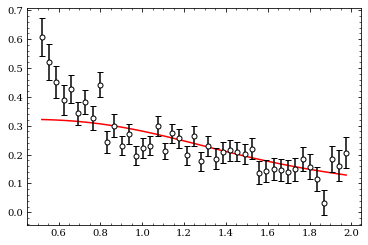

In [182]:
## Fit to find the rough value of $K$
#qseq,sqseq*seq_scale*ffseq,ffseq*sqerrseq*seq_scale

def knolle_qmodel(q,A,K):
    return A*(1+K*np.cos(q*3.54))

modelK = Model(knolle_qmodel)
paramsK = modelK.make_params()
paramsK.add('A',value=0.3,min=0.0,max=100.0)
paramsK.add('K',value=-10,min=-200,max=200)
resultK = modelK.fit(sqseq,q=qseq,weights=1.0/sqerrseq,params=paramsK,method='powell')
fig,ax = plt.subplots(1,1)
ax.errorbar(qseq,sqseq*seq_scale*ffseq,ffseq*sqerrseq*seq_scale,color='k',\
               marker='o',mfc='w',mec='k',ls=' ',capsize=3,zorder=10,ms=markersize)
ax.plot(qseq,resultK.best_fit*ffseq*seq_scale,'r-')
print(resultK.fit_report())